In [1]:
"""
STATISTIQUES DESCRIPTIVES - IMPACT DES ZFE SUR LE NO₂
Projet Python pour la Data Science - Analyse causale Grenoble & Paris
"""

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json
from shapely.geometry import Point, shape
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# ============================================================================
# 0. CHEMINS ET CHARGEMENT DES DONNÉES
# ============================================================================

HERE = Path().resolve()
ROOT = HERE.parent if 'zfe-scm' in str(HERE) else HERE
DATA = ROOT / "data"

print("=" * 80)
print("📊 STATISTIQUES DESCRIPTIVES - IMPACT DES ZFE SUR LE NO₂")
print("=" * 80)

# Charger les métadonnées ZFE
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
zfe_meta['first_date_debut'] = pd.to_datetime(zfe_meta['first_date_debut'])

# Dates de début des ZFE
grenoble_zfe_start = zfe_meta.loc[zfe_meta['publisher_zfe_id'] == 'GRENOBLE', 'first_date_debut'].iloc[0]
paris_zfe_start = zfe_meta.loc[zfe_meta['publisher_zfe_id'] == 'PARIS', 'first_date_debut'].iloc[0]

print(f"\n🎯 Dates clés :")
print(f"  • ZFE Grenoble : {grenoble_zfe_start.date()}")
print(f"  • ZFE Paris : {paris_zfe_start.date()}")

# Charger les données de pollution
grenoble_daily = pd.read_csv(DATA / "pollution_grenoble_no2_daily_clean.csv")
grenoble_daily['date'] = pd.to_datetime(grenoble_daily['date'])

paris_daily = pd.read_csv(DATA / "pollution_paris_no2_daily_clean.csv")
paris_daily['date'] = pd.to_datetime(paris_daily['date'])

# Charger les donneurs
donors_daily = pd.read_csv(DATA / "no2_all_stations_daily_clean.csv")
donors_daily['date'] = pd.to_datetime(donors_daily['date'])

print(f"\n📁 Données chargées :")
print(f"  • Grenoble : {len(grenoble_daily)} observations, {grenoble_daily['station_id'].nunique()} stations")
print(f"  • Paris : {len(paris_daily)} observations, {paris_daily['station_id'].nunique()} stations")
print(f"  • Donneurs : {len(donors_daily)} observations, {donors_daily['station_id'].nunique()} stations")


📊 STATISTIQUES DESCRIPTIVES - IMPACT DES ZFE SUR LE NO₂

🎯 Dates clés :
  • ZFE Grenoble : 2019-05-02
  • ZFE Paris : 2021-06-01

📁 Données chargées :
  • Grenoble : 5836 observations, 2 stations
  • Paris : 5268 observations, 2 stations
  • Donneurs : 28678 observations, 10 stations



1️⃣ CARTOGRAPHIE AVEC GEOPANDAS
✅ Carte sauvegardée : stats_desc_carte_zfe.png


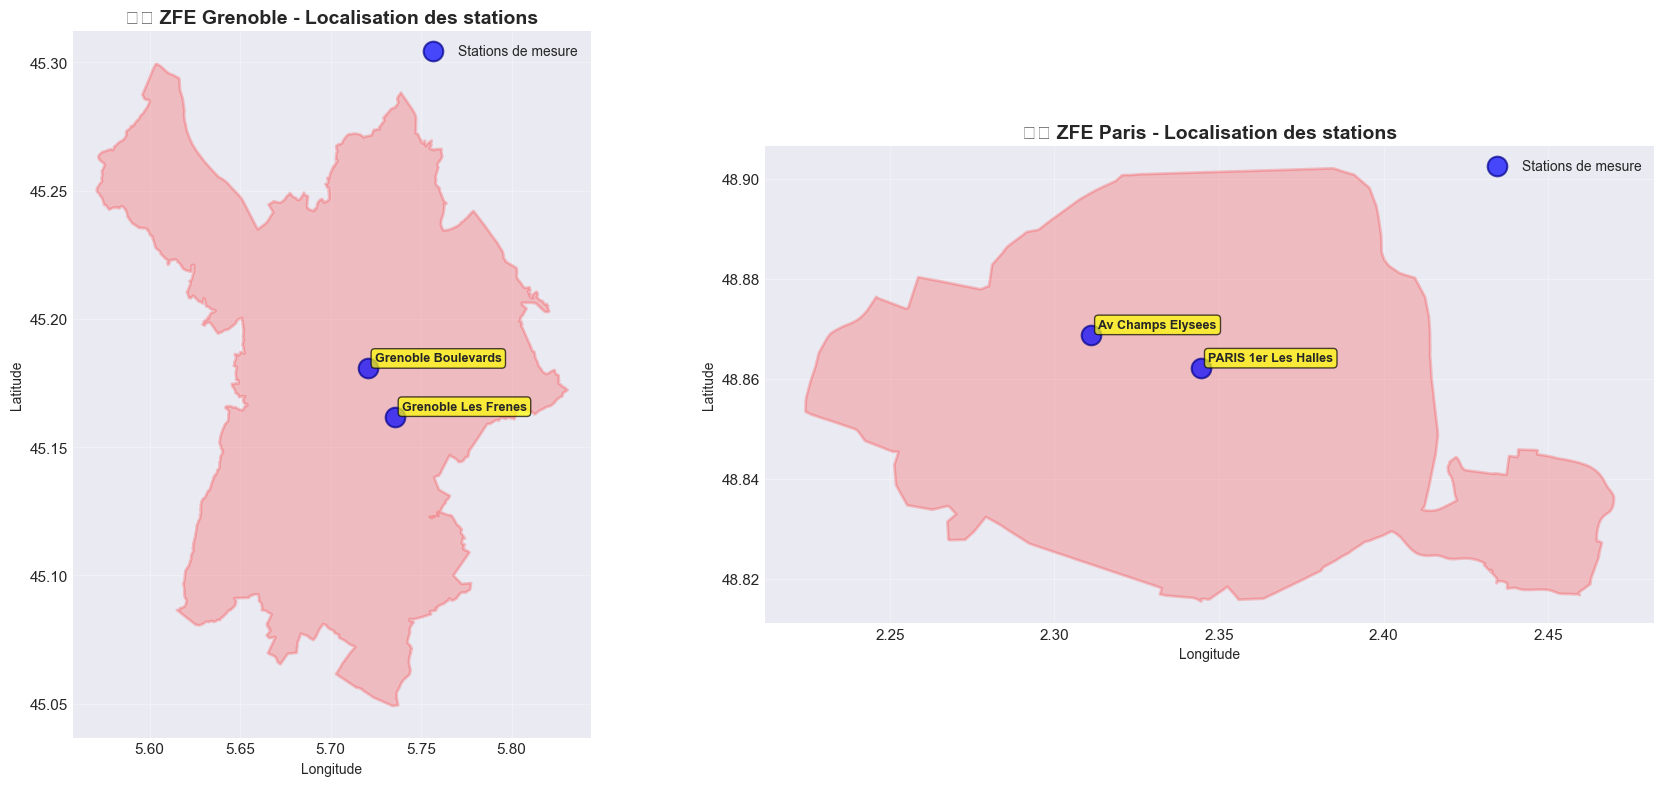

In [2]:
# ============================================================================
# 1. CARTOGRAPHIE - VISUALISATION GÉOGRAPHIQUE DES ZFE ET STATIONS
# ============================================================================

print("\n" + "=" * 80)
print("1️⃣ CARTOGRAPHIE AVEC GEOPANDAS")
print("=" * 80)

# Charger les périmètres ZFE
with open(DATA / "aires.geojson", encoding="utf-8") as f:
    zfe_geojson = json.load(f)

# Créer GeoDataFrame des ZFE
zfe_features = []
for feat in zfe_geojson['features']:
    pub = feat.get('publisher', {})
    zfe_id = pub.get('zfe_id')
    if zfe_id in ['GRENOBLE', 'PARIS']:
        zfe_features.append({
            'zfe_id': zfe_id,
            'nom': pub.get('nom'),
            'geometry': shape(feat['geometry'])
        })

gdf_zfe = gpd.GeoDataFrame(zfe_features, crs="EPSG:4326")

# Créer GeoDataFrame des stations
def create_stations_gdf(df, zfe_name):
    stations = df[['station_id', 'station_name', 'station_env', 'station_influence', 'lat', 'lon']].drop_duplicates()
    stations['geometry'] = stations.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
    stations['ville'] = zfe_name
    return gpd.GeoDataFrame(stations, crs="EPSG:4326")

gdf_grenoble = create_stations_gdf(grenoble_daily, 'Grenoble')
gdf_paris = create_stations_gdf(paris_daily, 'Paris')
gdf_stations = pd.concat([gdf_grenoble, gdf_paris], ignore_index=True)

# Créer une carte pour chaque ville
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for idx, (ville, ax) in enumerate(zip(['GRENOBLE', 'PARIS'], axes)):
    # Périmètre ZFE
    zfe_subset = gdf_zfe[gdf_zfe['zfe_id'] == ville]
    zfe_subset.plot(ax=ax, color='red', alpha=0.2, edgecolor='red', linewidth=2, label='Périmètre ZFE')
    
    # Stations
    stations_subset = gdf_stations[gdf_stations['ville'] == ville.capitalize()]
    stations_subset.plot(ax=ax, color='blue', markersize=200, alpha=0.7, 
                         edgecolor='darkblue', linewidth=1.5, label='Stations de mesure')
    
    # Annotations
    for _, station in stations_subset.iterrows():
        ax.annotate(station['station_name'], 
                   xy=(station.geometry.x, station.geometry.y),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax.set_title(f"🗺️ ZFE {ville.capitalize()} - Localisation des stations", fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_carte_zfe.png', dpi=300, bbox_inches='tight')
print("✅ Carte sauvegardée : stats_desc_carte_zfe.png")
plt.show()


2️⃣ ÉVOLUTION TEMPORELLE DU NO₂
✅ Graphique sauvegardé : stats_desc_evolution_temporelle.png


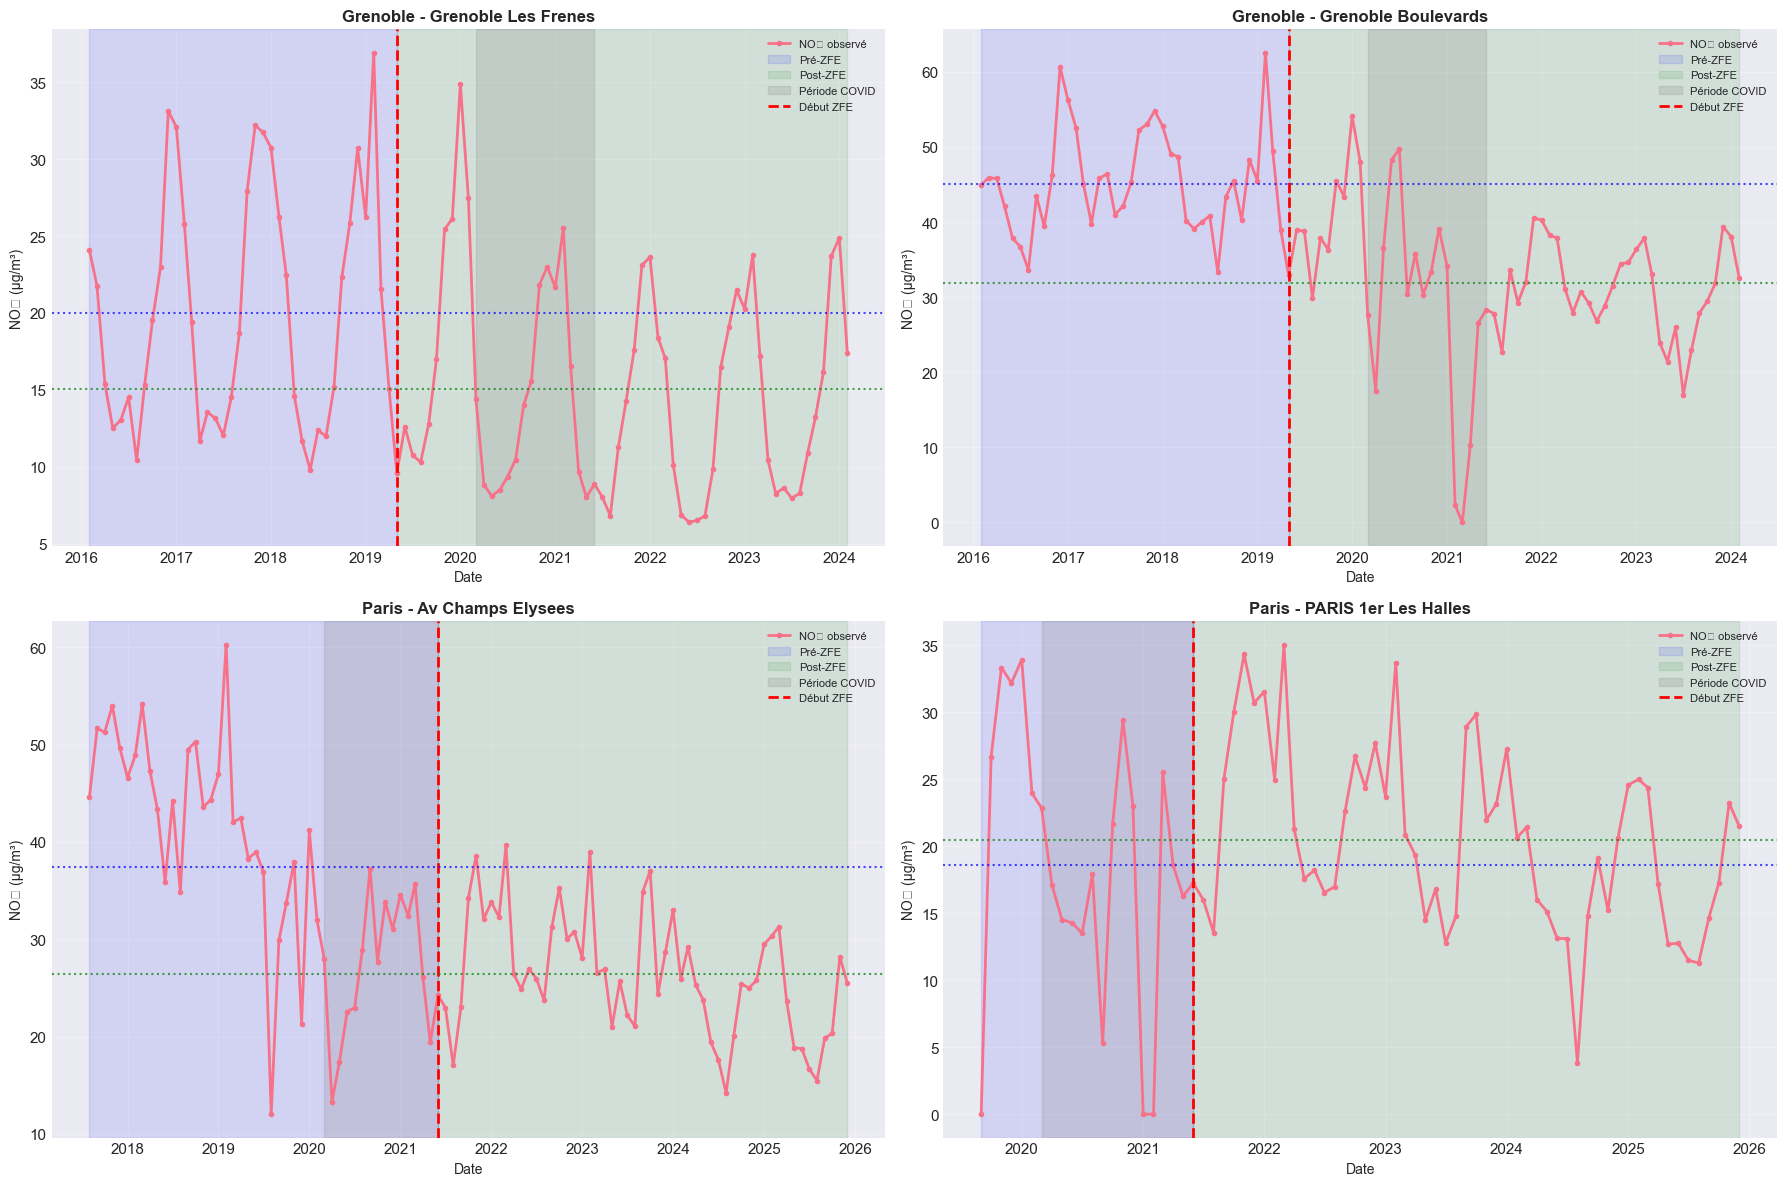

In [3]:
 #============================================================================
# 2. STATISTIQUES TEMPORELLES - ÉVOLUTION DU NO₂
# ============================================================================

print("\n" + "=" * 80)
print("2️⃣ ÉVOLUTION TEMPORELLE DU NO₂")
print("=" * 80)

def prepare_monthly_data(df, zfe_start):
    """Agrégation mensuelle avec marqueur pré/post ZFE"""
    monthly = df.set_index('date').groupby('station_id')['no2_ug_m3'].resample('MS').mean().reset_index()
    monthly['period'] = monthly['date'].apply(lambda x: 'Pré-ZFE' if x < zfe_start else 'Post-ZFE')
    # Exclure période COVID (mars 2020 - juin 2021)
    covid_mask = (monthly['date'] >= '2020-03-01') & (monthly['date'] <= '2021-06-01')
    monthly['period_clean'] = monthly['period'].copy()
    monthly.loc[covid_mask, 'period_clean'] = 'COVID (exclu)'
    return monthly

grenoble_monthly = prepare_monthly_data(grenoble_daily, grenoble_zfe_start)
paris_monthly = prepare_monthly_data(paris_daily, paris_zfe_start)

# Graphique multi-stations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

datasets = [
    (grenoble_monthly, 'Grenoble', grenoble_zfe_start),
    (paris_monthly, 'Paris', paris_zfe_start)
]

for idx, (monthly_df, ville, zfe_date) in enumerate(datasets):
    stations = monthly_df['station_id'].unique()
    
    for i, station_id in enumerate(stations[:2]):  # 2 stations max par ville
        ax = axes[idx * 2 + i]
        station_data = monthly_df[monthly_df['station_id'] == station_id]
        station_name = grenoble_daily[grenoble_daily['station_id'] == station_id]['station_name'].iloc[0] if ville == 'Grenoble' else paris_daily[paris_daily['station_id'] == station_id]['station_name'].iloc[0]
        
        # Ligne temporelle
        ax.plot(station_data['date'], station_data['no2_ug_m3'], 
               linewidth=2, marker='o', markersize=3, label='NO₂ observé')
        
        # Zones colorées
        pre_data = station_data[station_data['period'] == 'Pré-ZFE']
        post_data = station_data[station_data['period'] == 'Post-ZFE']
        
        ax.axvspan(station_data['date'].min(), zfe_date, alpha=0.1, color='blue', label='Pré-ZFE')
        ax.axvspan(zfe_date, station_data['date'].max(), alpha=0.1, color='green', label='Post-ZFE')
        
        # Zone COVID
        ax.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-06-01'), 
                  alpha=0.2, color='gray', label='Période COVID')
        
        # Ligne verticale ZFE
        ax.axvline(zfe_date, color='red', linestyle='--', linewidth=2, label=f'Début ZFE')
        
        # Moyennes pré/post
        pre_mean = pre_data['no2_ug_m3'].mean()
        post_mean = post_data['no2_ug_m3'].mean()
        ax.axhline(pre_mean, color='blue', linestyle=':', alpha=0.7)
        ax.axhline(post_mean, color='green', linestyle=':', alpha=0.7)
        
        ax.set_title(f"{ville} - {station_name}", fontsize=12, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('NO₂ (µg/m³)', fontsize=10)
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_evolution_temporelle.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : stats_desc_evolution_temporelle.png")
plt.show()



3️⃣ COMPARAISONS PRÉ/POST ZFE

📊 TABLEAU RÉCAPITULATIF DES STATISTIQUES
   ville         station_name station_type  pre_mean  post_mean  reduction_pct       p_value
Grenoble  Grenoble Les Frenes         Fond 20.182203  15.080312     -25.279158  4.266285e-38
Grenoble  Grenoble Boulevards       Trafic 45.297119  33.231513     -26.636585 3.923517e-117
   Paris    Av Champs Elysees       Trafic 42.095135  26.396017     -37.294376 4.699024e-152
   Paris PARIS 1er Les Halles         Fond 28.728378  20.445902     -28.830297  1.051356e-18
✅ Tableau sauvegardé : stats_desc_tableau_recapitulatif.csv
✅ Graphique sauvegardé : stats_desc_comparaisons_pre_post.png


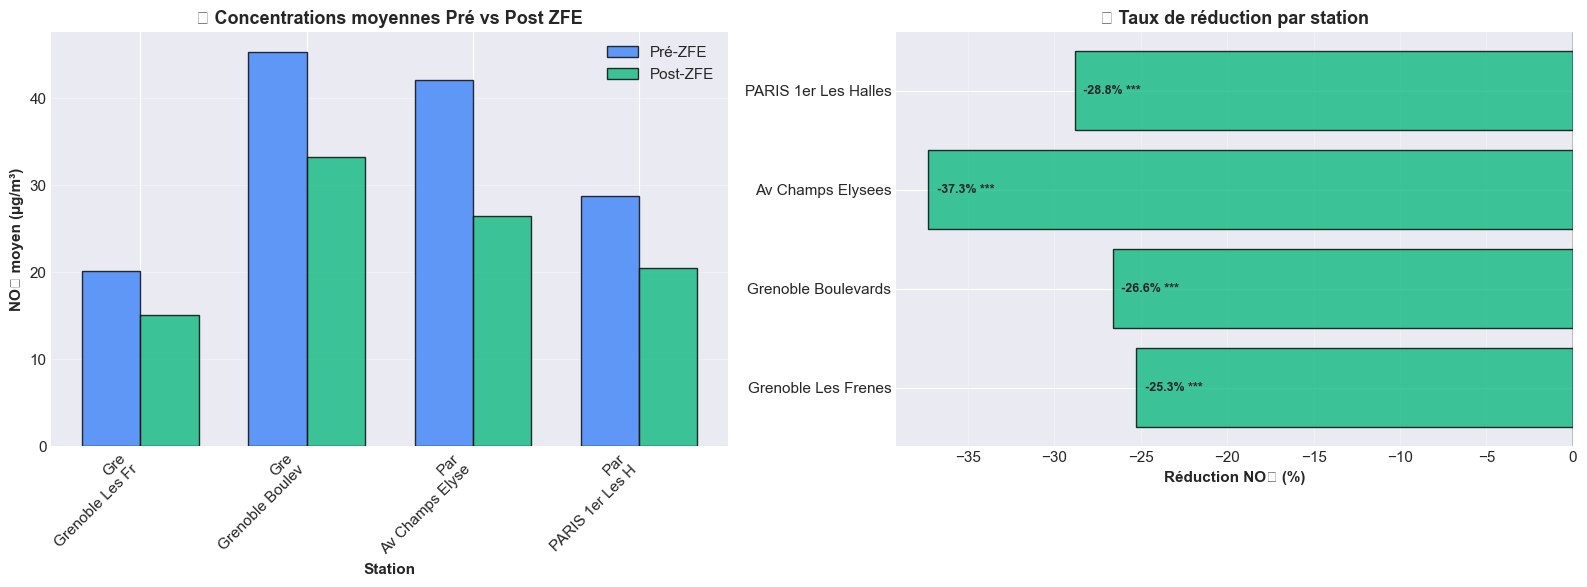

In [9]:
# ============================================================================
# 3. COMPARAISONS PRÉ/POST ZFE - STATISTIQUES DESCRIPTIVES
# ============================================================================

print("\n" + "=" * 80)
print("3️⃣ COMPARAISONS PRÉ/POST ZFE")
print("=" * 80)

def compute_pre_post_stats(df, zfe_start, ville):
    """Calculer statistiques pré/post pour chaque station"""
    results = []
    
    # Exclure COVID
    covid_mask = (df['date'] >= '2020-03-01') & (df['date'] <= '2021-06-01')
    df_clean = df[~covid_mask].copy()
    
    for station_id in df_clean['station_id'].unique():
        station_data = df_clean[df_clean['station_id'] == station_id]
        station_name = station_data['station_name'].iloc[0]
        station_type = station_data['station_influence'].iloc[0]
        
        # Séparer pré/post
        pre = station_data[station_data['date'] < zfe_start]['no2_ug_m3']
        post = station_data[station_data['date'] >= zfe_start]['no2_ug_m3']
        
        if len(pre) > 30 and len(post) > 30:  # Minimum 30 obs
            # Statistiques descriptives
            pre_mean, pre_std, pre_median = pre.mean(), pre.std(), pre.median()
            post_mean, post_std, post_median = post.mean(), post.std(), post.median()
            
            # Réduction
            reduction_abs = post_mean - pre_mean
            reduction_pct = (reduction_abs / pre_mean) * 100
            
            # Test statistique (t-test)
            t_stat, p_value = stats.ttest_ind(pre, post)
            
            results.append({
                'ville': ville,
                'station_id': station_id,
                'station_name': station_name,
                'station_type': station_type,
                'pre_mean': pre_mean,
                'pre_std': pre_std,
                'pre_median': pre_median,
                'post_mean': post_mean,
                'post_std': post_std,
                'post_median': post_median,
                'reduction_abs': reduction_abs,
                'reduction_pct': reduction_pct,
                't_stat': t_stat,
                'p_value': p_value,
                'n_obs_pre': len(pre),
                'n_obs_post': len(post)
            })
    
    return pd.DataFrame(results)

stats_grenoble = compute_pre_post_stats(grenoble_daily, grenoble_zfe_start, 'Grenoble')
stats_paris = compute_pre_post_stats(paris_daily, paris_zfe_start, 'Paris')
stats_all = pd.concat([stats_grenoble, stats_paris], ignore_index=True)

print("\n📊 TABLEAU RÉCAPITULATIF DES STATISTIQUES")
print("=" * 120)
print(stats_all[['ville', 'station_name', 'station_type', 'pre_mean', 'post_mean', 
                 'reduction_pct', 'p_value']].to_string(index=False))
print("=" * 120)

# Sauvegarder le tableau
stats_all.to_csv(DATA / 'stats_desc_tableau_recapitulatif.csv', index=False)
print("✅ Tableau sauvegardé : stats_desc_tableau_recapitulatif.csv")

# Graphique comparatif
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot moyennes
ax1 = axes[0]
x_pos = np.arange(len(stats_all))
width = 0.35
ax1.bar(x_pos - width/2, stats_all['pre_mean'], width, label='Pré-ZFE', 
       color='#3b82f6', alpha=0.8, edgecolor='black')
ax1.bar(x_pos + width/2, stats_all['post_mean'], width, label='Post-ZFE', 
       color='#10b981', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Station', fontweight='bold')
ax1.set_ylabel('NO₂ moyen (µg/m³)', fontweight='bold')
ax1.set_title('📊 Concentrations moyennes Pré vs Post ZFE', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"{row['ville'][:3]}\n{row['station_name'][:15]}" 
                     for _, row in stats_all.iterrows()], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Barplot réductions
ax2 = axes[1]
colors = ['#ef4444' if x > 0 else '#10b981' for x in stats_all['reduction_pct']]
bars = ax2.barh(stats_all['station_name'], stats_all['reduction_pct'], color=colors, alpha=0.8, edgecolor='black')
ax2.set_xlabel('Réduction NO₂ (%)', fontweight='bold')
ax2.set_title('📉 Taux de réduction par station', fontsize=13, fontweight='bold')
ax2.axvline(0, color='black', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

# Annotations p-values
for i, (idx, row) in enumerate(stats_all.iterrows()):
    significance = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else 'ns'
    ax2.text(row['reduction_pct'] + 0.5, i, f"{row['reduction_pct']:.1f}% {significance}", 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_comparaisons_pre_post.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : stats_desc_comparaisons_pre_post.png")
plt.show()



4️⃣ DISTRIBUTIONS DES CONCENTRATIONS
✅ Graphique sauvegardé : stats_desc_distributions.png


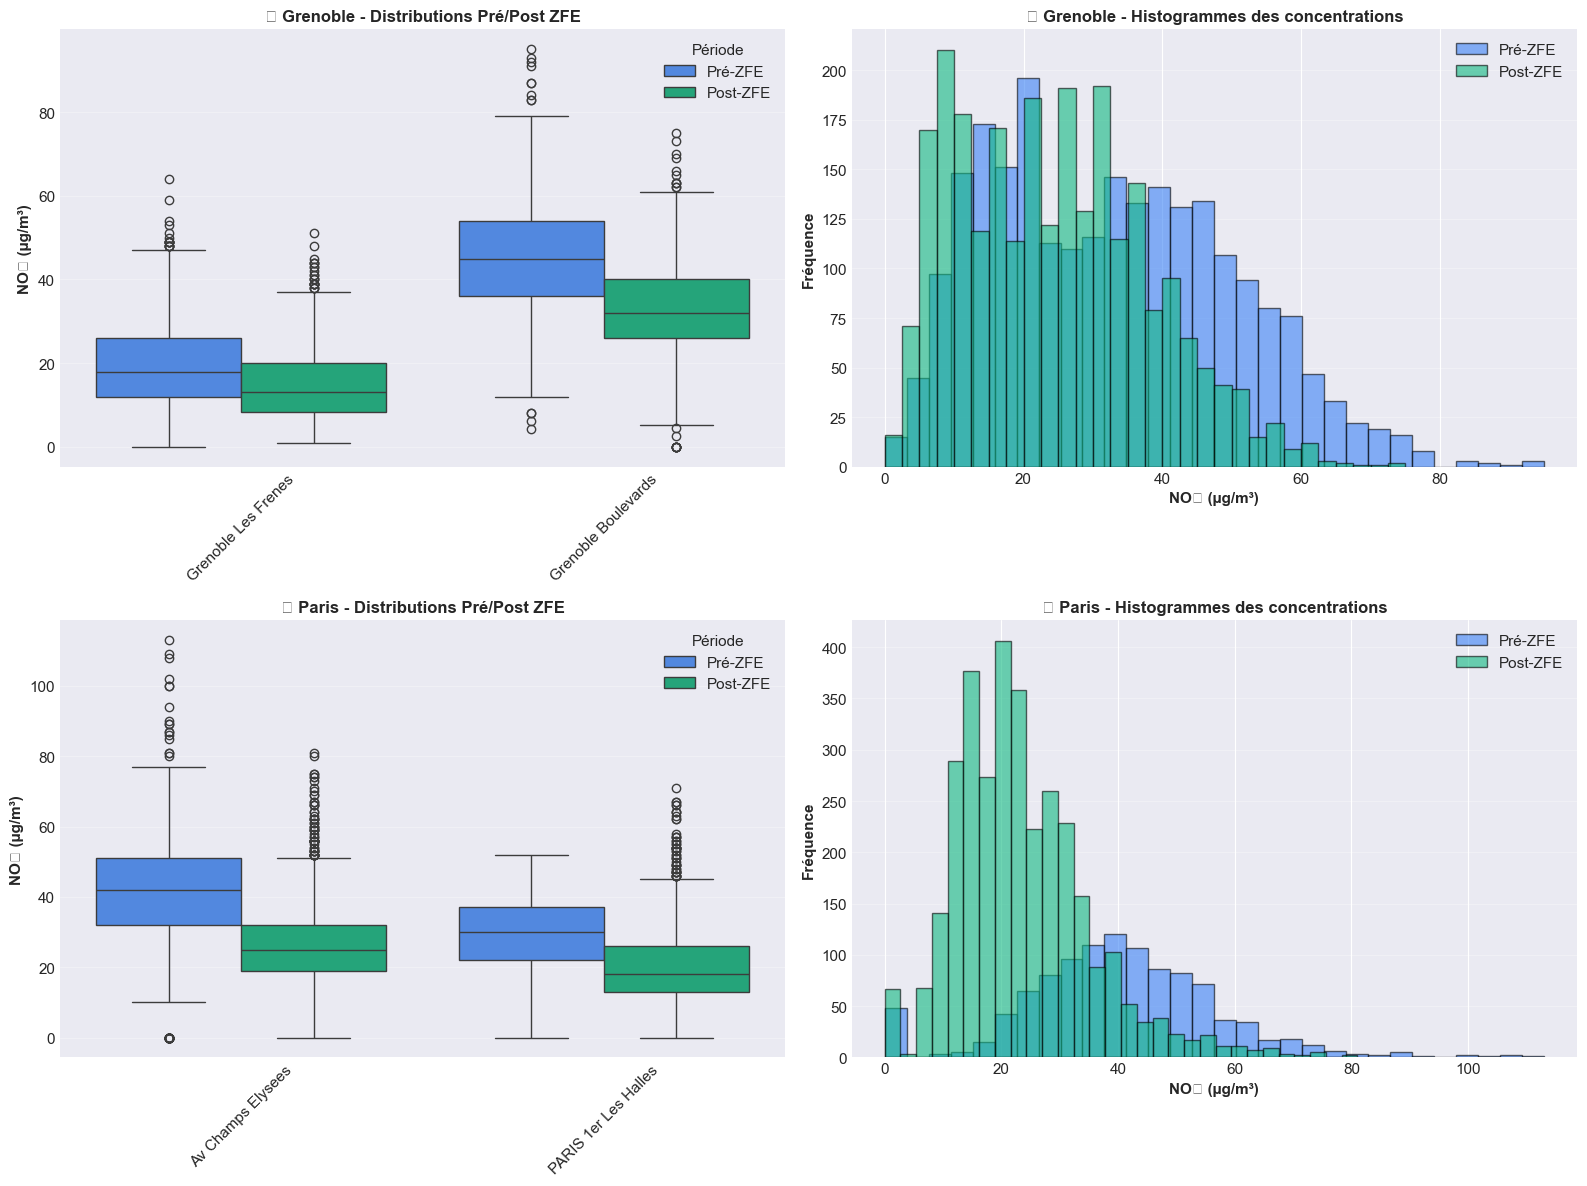

In [10]:
# ============================================================================
# 4. DISTRIBUTIONS ET BOXPLOTS
# ============================================================================

print("\n" + "=" * 80)
print("4️⃣ DISTRIBUTIONS DES CONCENTRATIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Données pour plotting
for idx, (df, zfe_date, ville) in enumerate([(grenoble_daily, grenoble_zfe_start, 'Grenoble'),
                                               (paris_daily, paris_zfe_start, 'Paris')]):
    # Exclure COVID
    covid_mask = (df['date'] >= '2020-03-01') & (df['date'] <= '2021-06-01')
    df_clean = df[~covid_mask].copy()
    df_clean['period'] = df_clean['date'].apply(lambda x: 'Pré-ZFE' if x < zfe_date else 'Post-ZFE')
    
    # Boxplot
    ax1 = axes[idx, 0]
    sns.boxplot(data=df_clean, x='station_name', y='no2_ug_m3', hue='period', ax=ax1, palette=['#3b82f6', '#10b981'])
    ax1.set_title(f'📦 {ville} - Distributions Pré/Post ZFE', fontsize=12, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('NO₂ (µg/m³)', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(title='Période')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Histogramme
    ax2 = axes[idx, 1]
    for period, color in [('Pré-ZFE', '#3b82f6'), ('Post-ZFE', '#10b981')]:
        data = df_clean[df_clean['period'] == period]['no2_ug_m3']
        ax2.hist(data, bins=30, alpha=0.6, label=period, color=color, edgecolor='black')
    ax2.set_title(f'📊 {ville} - Histogrammes des concentrations', fontsize=12, fontweight='bold')
    ax2.set_xlabel('NO₂ (µg/m³)', fontweight='bold')
    ax2.set_ylabel('Fréquence', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_distributions.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : stats_desc_distributions.png")
plt.show()


5️⃣ ANALYSE SAISONNIÈRE
✅ Décomposition Grenoble sauvegardée


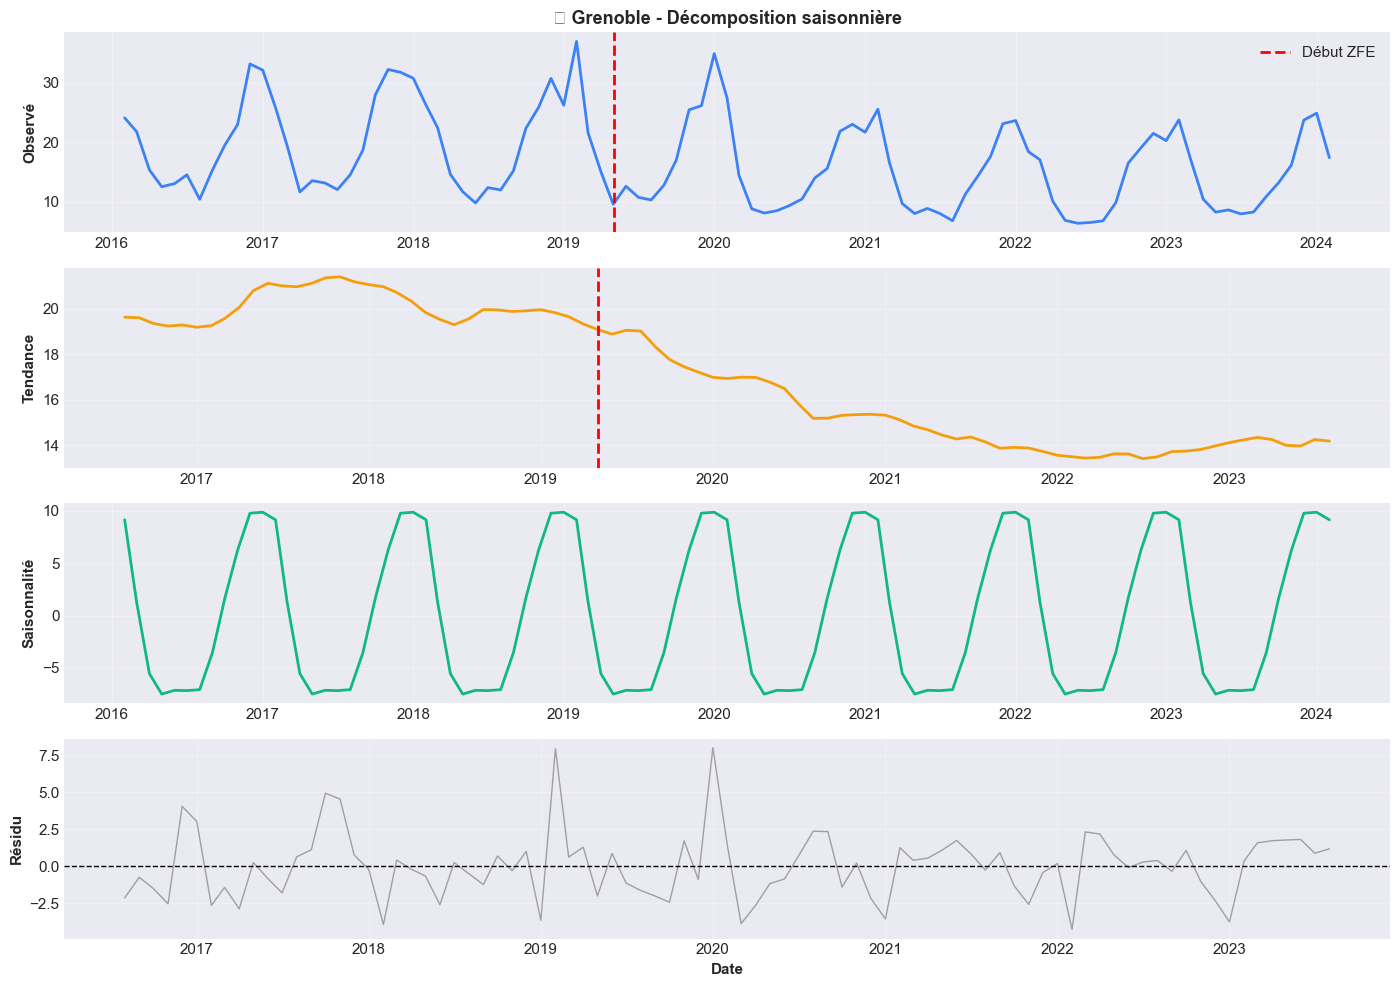

✅ Profils mensuels sauvegardés


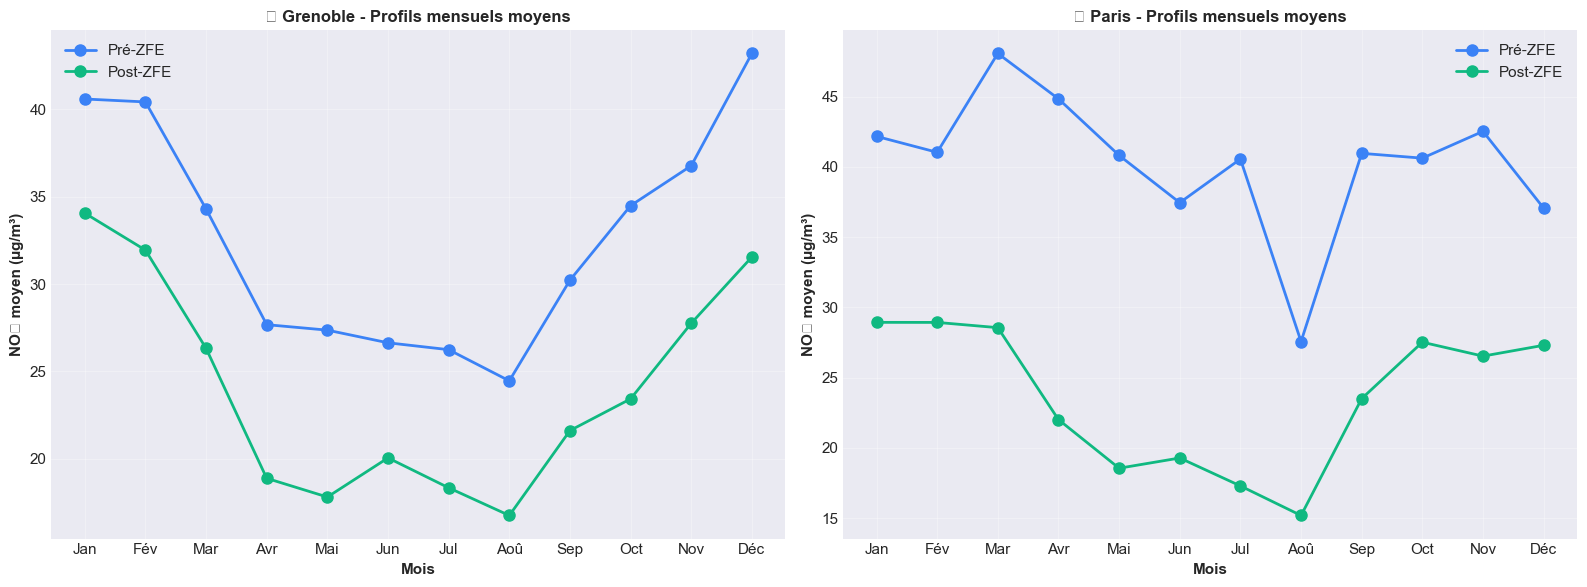

In [11]:
# ============================================================================
# 5. ANALYSE SAISONNIÈRE
# ============================================================================

print("\n" + "=" * 80)
print("5️⃣ ANALYSE SAISONNIÈRE")
print("=" * 80)

def plot_seasonal_patterns(df, zfe_date, ville, station_id):
    """Analyser et tracer les patterns saisonniers"""
    station_data = df[df['station_id'] == station_id].copy()
    station_data = station_data.set_index('date')['no2_ug_m3'].resample('MS').mean()
    
    # Décomposition saisonnière
    if len(station_data) >= 24:  # Minimum 2 ans
        decomposition = seasonal_decompose(station_data, model='additive', period=12)
        
        fig, axes = plt.subplots(4, 1, figsize=(14, 10))
        
        # Série originale
        axes[0].plot(station_data.index, station_data.values, linewidth=2, color='#3b82f6')
        axes[0].axvline(zfe_date, color='red', linestyle='--', linewidth=2, label='Début ZFE')
        axes[0].set_ylabel('Observé', fontweight='bold')
        axes[0].set_title(f'🍂 {ville} - Décomposition saisonnière', fontsize=13, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Tendance
        axes[1].plot(decomposition.trend.index, decomposition.trend.values, linewidth=2, color='#f59e0b')
        axes[1].axvline(zfe_date, color='red', linestyle='--', linewidth=2)
        axes[1].set_ylabel('Tendance', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        # Saisonnalité
        axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, linewidth=2, color='#10b981')
        axes[2].set_ylabel('Saisonnalité', fontweight='bold')
        axes[2].grid(True, alpha=0.3)
        
        # Résidu
        axes[3].plot(decomposition.resid.index, decomposition.resid.values, linewidth=1, color='gray', alpha=0.7)
        axes[3].axhline(0, color='black', linestyle='--', linewidth=1)
        axes[3].set_ylabel('Résidu', fontweight='bold')
        axes[3].set_xlabel('Date', fontweight='bold')
        axes[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

# Grenoble Les Frênes
fig_grenoble = plot_seasonal_patterns(grenoble_daily, grenoble_zfe_start, 'Grenoble', 
                                     grenoble_daily['station_id'].iloc[0])
if fig_grenoble:
    fig_grenoble.savefig(DATA / 'stats_desc_saisonnalite_grenoble.png', dpi=300, bbox_inches='tight')
    print("✅ Décomposition Grenoble sauvegardée")
    plt.show()

# Profils mensuels moyens
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (df, zfe_date, ville) in enumerate([(grenoble_daily, grenoble_zfe_start, 'Grenoble'),
                                               (paris_daily, paris_zfe_start, 'Paris')]):
    covid_mask = (df['date'] >= '2020-03-01') & (df['date'] <= '2021-06-01')
    df_clean = df[~covid_mask].copy()
    df_clean['month'] = df_clean['date'].dt.month
    df_clean['period'] = df_clean['date'].apply(lambda x: 'Pré-ZFE' if x < zfe_date else 'Post-ZFE')
    
    monthly_avg = df_clean.groupby(['month', 'period'])['no2_ug_m3'].mean().reset_index()
    
    ax = axes[idx]
    for period, color in [('Pré-ZFE', '#3b82f6'), ('Post-ZFE', '#10b981')]:
        data = monthly_avg[monthly_avg['period'] == period]
        ax.plot(data['month'], data['no2_ug_m3'], marker='o', linewidth=2, 
               markersize=8, label=period, color=color)
    
    ax.set_title(f'📅 {ville} - Profils mensuels moyens', fontsize=12, fontweight='bold')
    ax.set_xlabel('Mois', fontweight='bold')
    ax.set_ylabel('NO₂ moyen (µg/m³)', fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
                       'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_profils_mensuels.png', dpi=300, bbox_inches='tight')
print("✅ Profils mensuels sauvegardés")
plt.show()



6️⃣ COMPARAISON STATIONS TRAITÉES VS DONNEUSES
✅ Comparaison donneurs sauvegardée


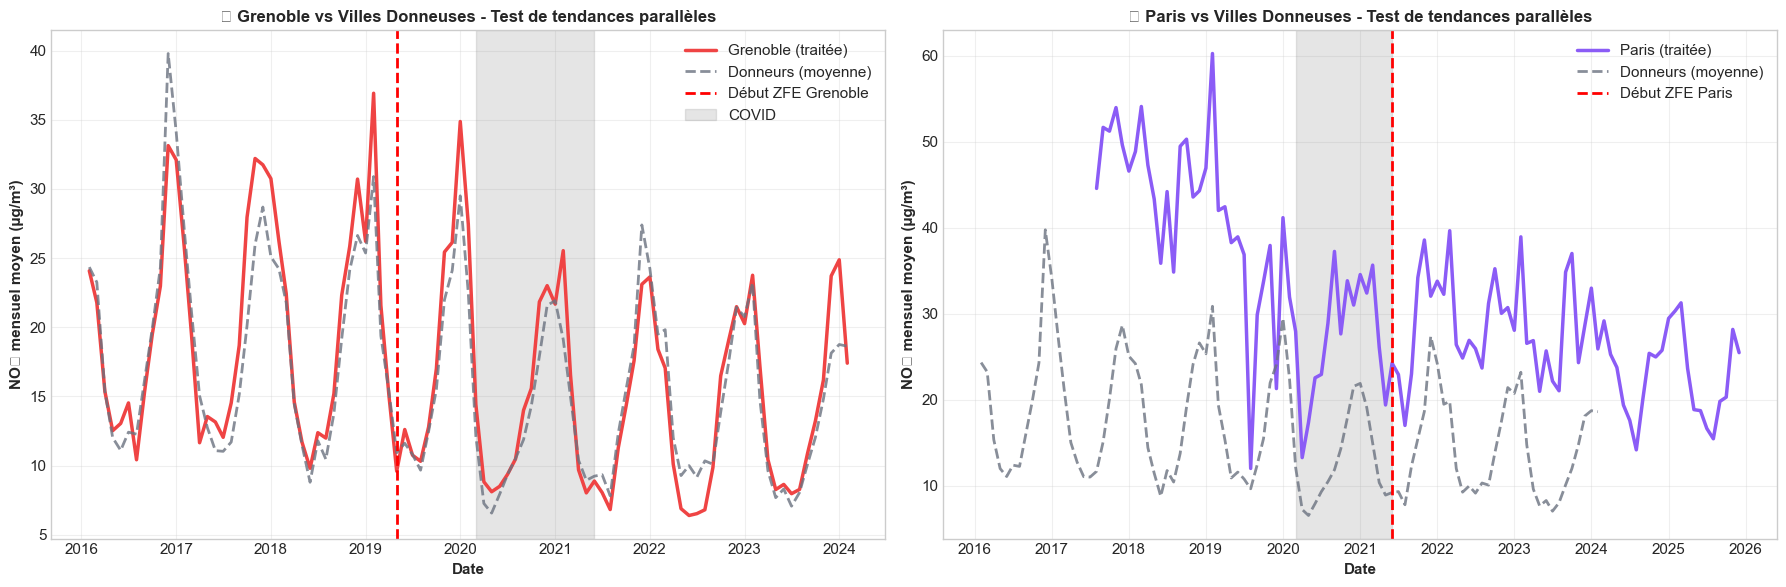

In [14]:
# ============================================================================
# 6. COMPARAISON AVEC LES DONNEURS (TENDANCES PARALLÈLES)
# ============================================================================

print("\n" + "=" * 80)
print("6️⃣ COMPARAISON STATIONS TRAITÉES VS DONNEUSES")
print("=" * 80)

# Moyenne mensuelle tous les donneurs
donors_monthly = donors_daily.set_index('date')['no2_ug_m3'].resample('MS').mean()

# Comparaison Grenoble
grenoble_station = grenoble_daily['station_id'].iloc[0]
grenoble_ts = grenoble_daily[grenoble_daily['station_id'] == grenoble_station].set_index('date')['no2_ug_m3'].resample('MS').mean()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Grenoble vs Donneurs
ax1 = axes[0]
ax1.plot(grenoble_ts.index, grenoble_ts.values, linewidth=2.5, label='Grenoble (traitée)', color='#ef4444')
ax1.plot(donors_monthly.index, donors_monthly.values, linewidth=2, label='Donneurs (moyenne)', 
        color='#6b7280', linestyle='--', alpha=0.8)
ax1.axvline(grenoble_zfe_start, color='red', linestyle='--', linewidth=2, label='Début ZFE Grenoble')
ax1.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-06-01'), alpha=0.2, color='gray', label='COVID')
ax1.set_title('🔍 Grenoble vs Villes Donneuses - Test de tendances parallèles', 
             fontsize=12, fontweight='bold')
ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('NO₂ mensuel moyen (µg/m³)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Paris vs Donneurs
paris_station = paris_daily['station_id'].iloc[0]
paris_ts = paris_daily[paris_daily['station_id'] == paris_station].set_index('date')['no2_ug_m3'].resample('MS').mean()

ax2 = axes[1]
ax2.plot(paris_ts.index, paris_ts.values, linewidth=2.5, label='Paris (traitée)', color='#8b5cf6')
ax2.plot(donors_monthly.index, donors_monthly.values, linewidth=2, label='Donneurs (moyenne)', 
        color='#6b7280', linestyle='--', alpha=0.8)
ax2.axvline(paris_zfe_start, color='red', linestyle='--', linewidth=2, label='Début ZFE Paris')
ax2.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-06-01'), alpha=0.2, color='gray')
ax2.set_title('🔍 Paris vs Villes Donneuses - Test de tendances parallèles', 
             fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontweight='bold')
ax2.set_ylabel('NO₂ mensuel moyen (µg/m³)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_comparaison_donneurs.png', dpi=300, bbox_inches='tight')
print("✅ Comparaison donneurs sauvegardée")
plt.show()


   ---------------------------------------- 0/2 [geographiclib]
   ---------------------------------------- 0/2 [geographiclib]
   ---------------------------------------- 0/2 [geographiclib]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   ---------------------------------------- 2/2 [geopy]

Note: you may need to 

Analyse des donneuses

🔍 ANALYSE APPROFONDIE DES STATIONS DONNEUSES

📊 Données chargées :
  • Stations donneuses : 10
  • Observations totales : 28,678
  • Période : 2016-02-05 → 2024-02-04

1️⃣ MÉTADONNÉES DES STATIONS DONNEUSES

📋 TABLE DES STATIONS DONNEUSES :
           ville        station_name station_env station_influence  n_obs  no2_mean  duree_jours
          Voiron       Voiron Urbain     Urbaine              Fond   2907 15.449776         2921
        Grenoble Grenoble PeriurbSud Périurbaine              Fond   2920  9.636333         2921
     Gresivaudan Gresivaudan Periurb Périurbaine              Fond   2921 13.729589         2921
             GAP     GAP JEAN JAURES     Urbaine            Trafic   2921 25.602191         2921
Bourgoin-Jallieu    Bourgoin-Jallieu     Urbaine              Fond   2647 11.431636         2921
        CHAMBERY    CHAMBERY LE HAUT     Urbaine              Fond   2787 13.933262         2921
           SAINT          SAINT JEAN     Urbaine              Fond   2916 10.849

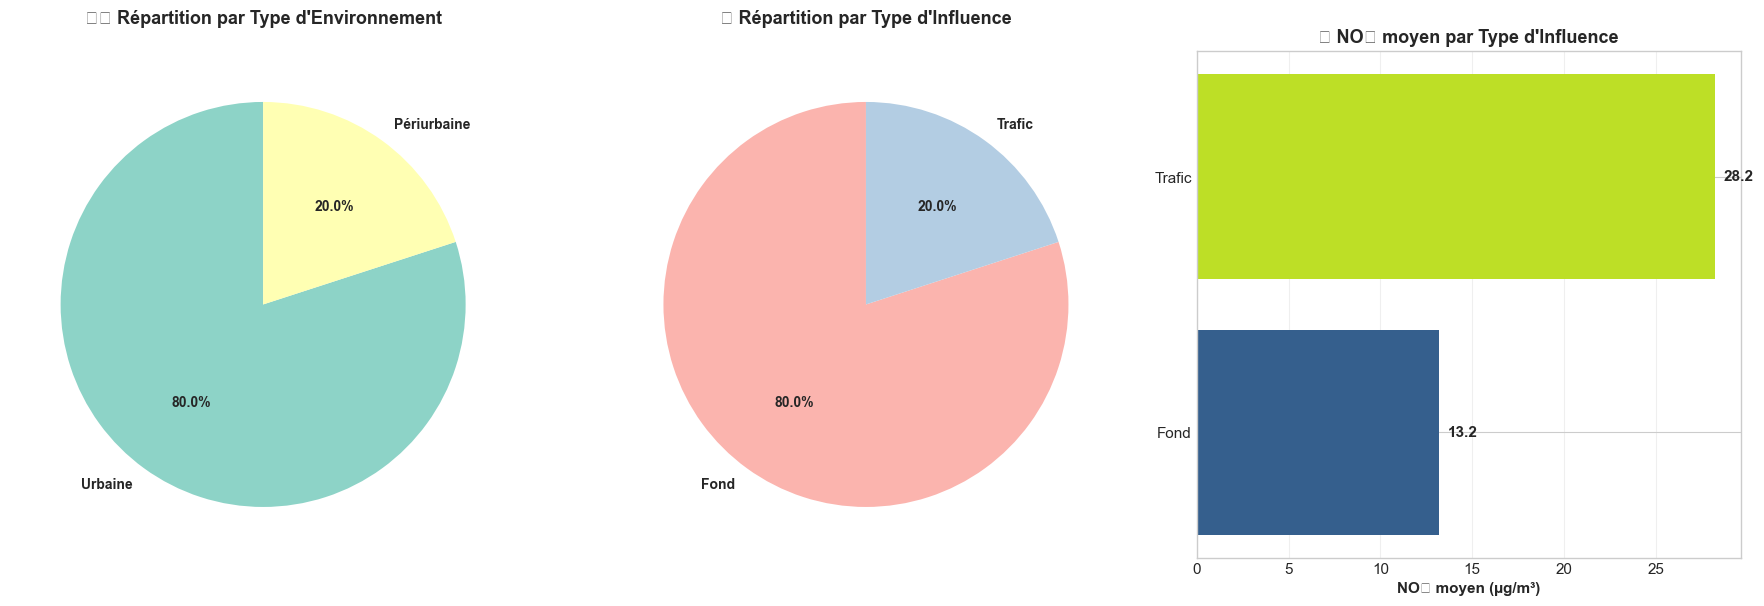


3️⃣ CARTOGRAPHIE GÉOGRAPHIQUE DES DONNEURS
✅ Carte France sauvegardée : stats_donneurs_carte_france.png


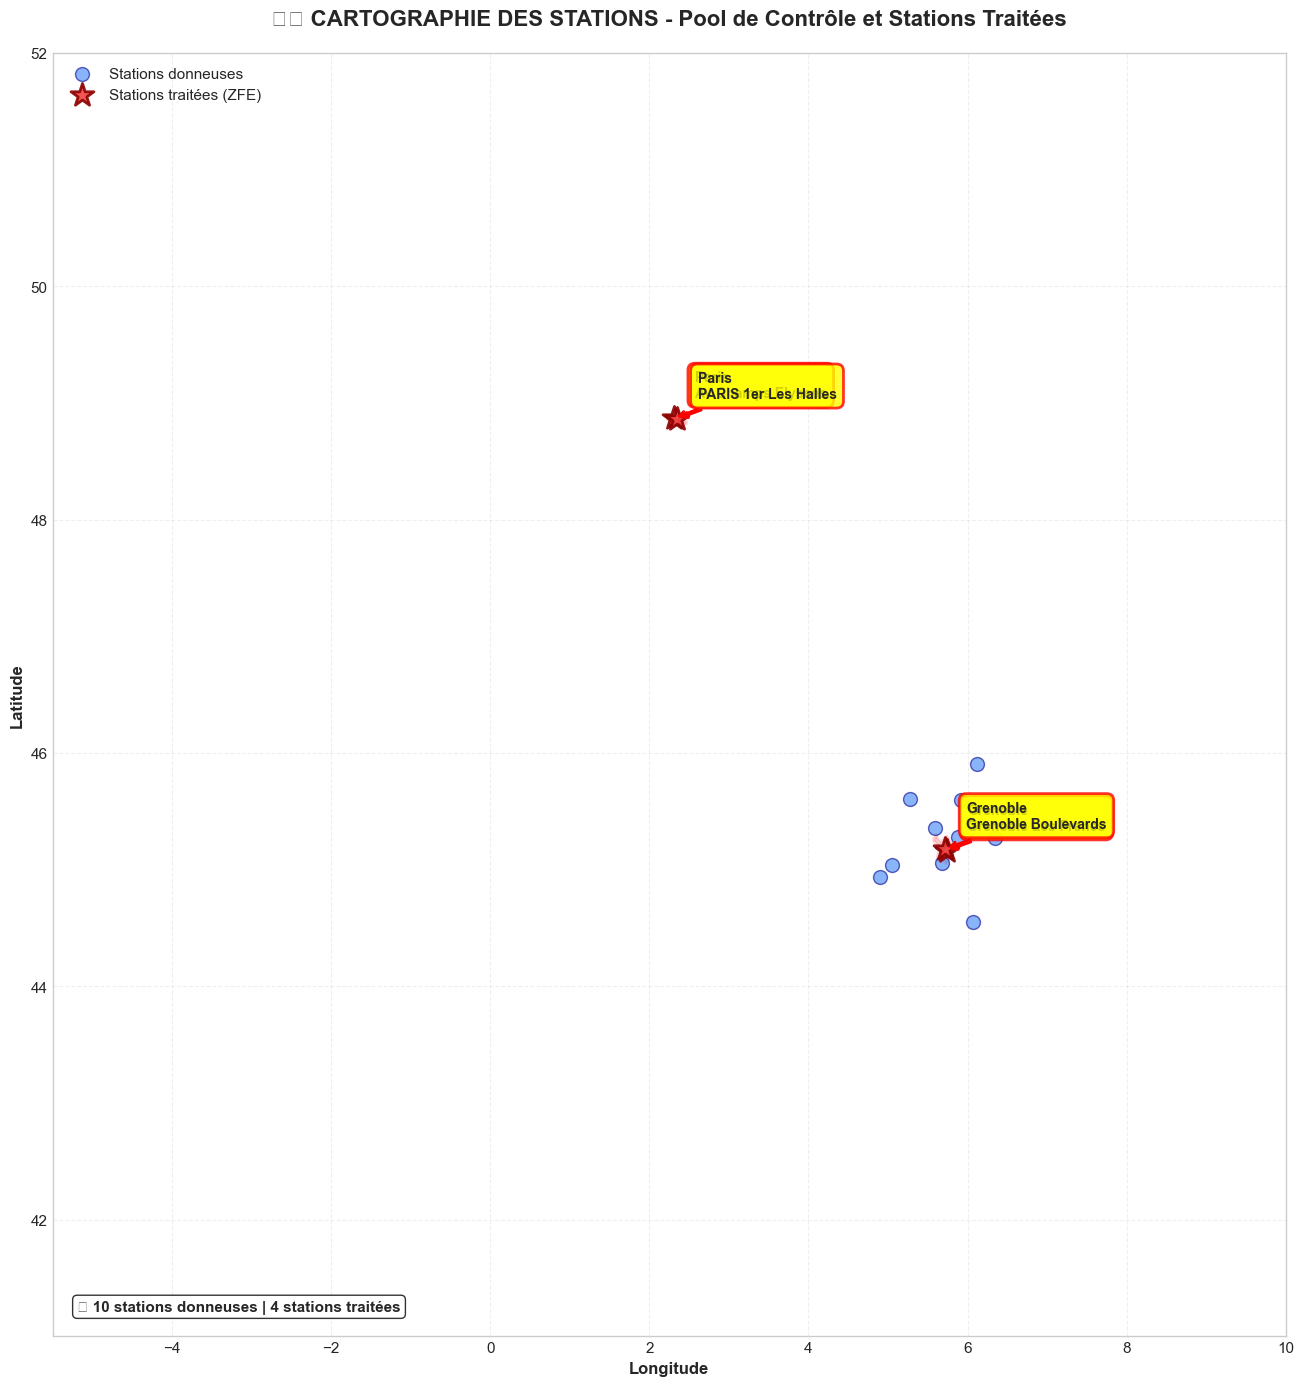


4️⃣ CARTES RÉGIONALES DÉTAILLÉES
  ⚠️  Aucun donneur trouvé dans la région Île-de-France
✅ Cartes régionales sauvegardées : stats_donneurs_cartes_regionales.png


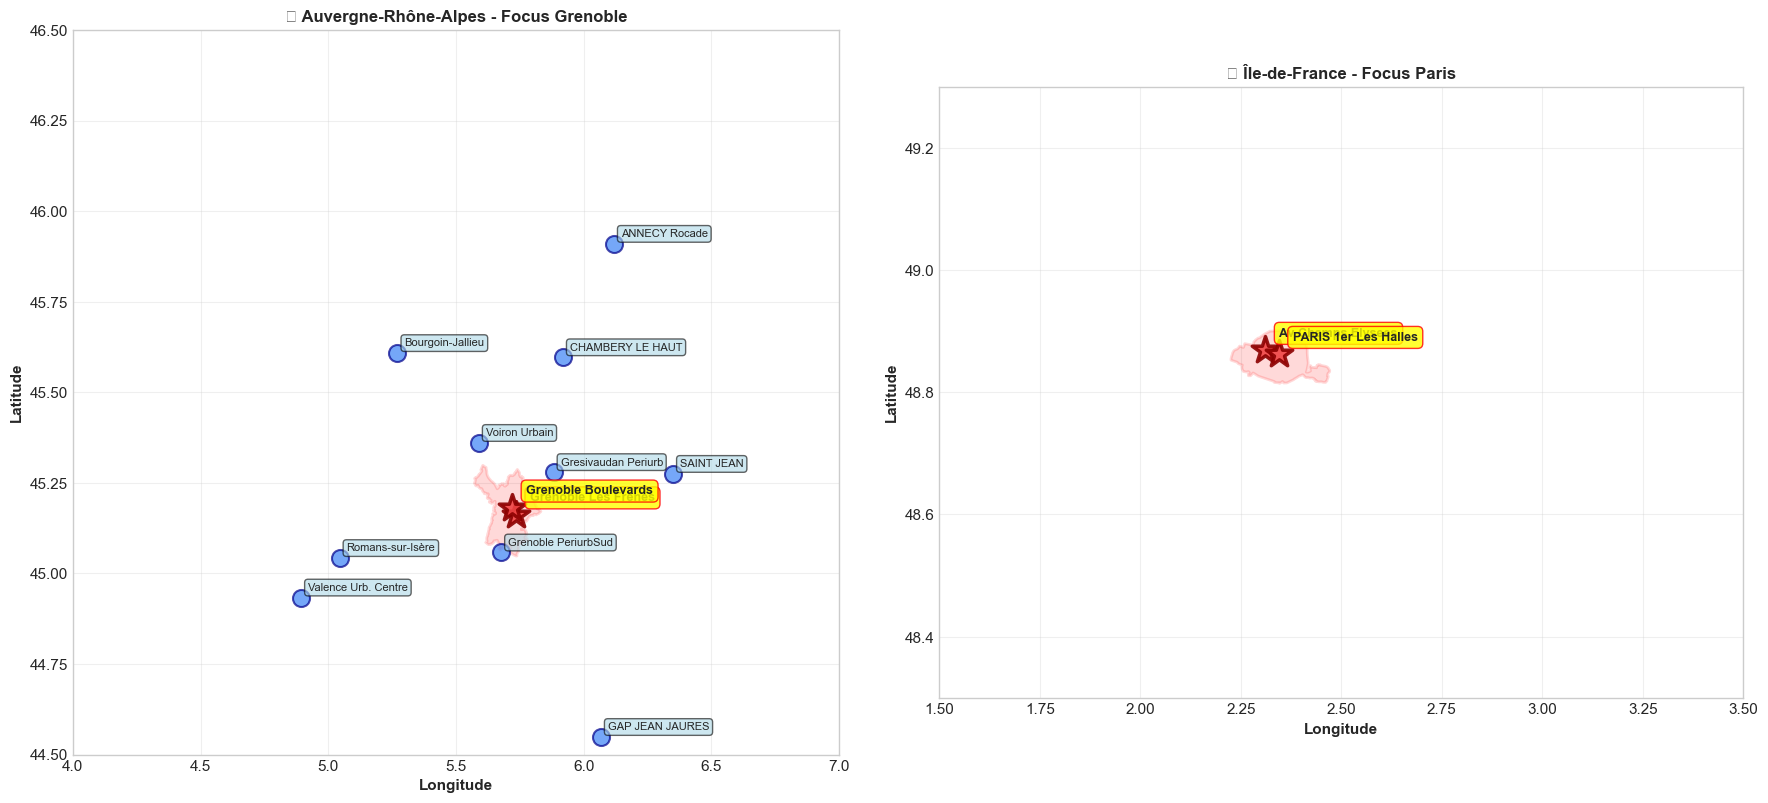


5️⃣ ANALYSE DE PROXIMITÉ GÉOGRAPHIQUE

📍 TOP 10 DONNEURS LES PLUS PROCHES :

Station traitée : Grenoble Les Frenes
     donor_ville       donor_station  distance_km  donor_no2_mean
        Grenoble Grenoble PeriurbSud    12.463055        9.636333
     Gresivaudan Gresivaudan Periurb    17.434986       13.729589
          Voiron       Voiron Urbain    24.843812       15.449776
           SAINT          SAINT JEAN    49.840206       10.849228
        CHAMBERY    CHAMBERY LE HAUT    50.401286       13.933262
Romans-sur-Isère    Romans-sur-Isère    56.004318       12.080081
Bourgoin-Jallieu    Bourgoin-Jallieu    61.523730       11.431636
         Valence Valence Urb. Centre    71.032194       18.397383
             GAP     GAP JEAN JAURES    73.017844       25.602191
          ANNECY       ANNECY Rocade    88.322621       30.847899

Station traitée : Grenoble Boulevards
     donor_ville       donor_station  distance_km  donor_no2_mean
        Grenoble Grenoble PeriurbSud    14.087797    

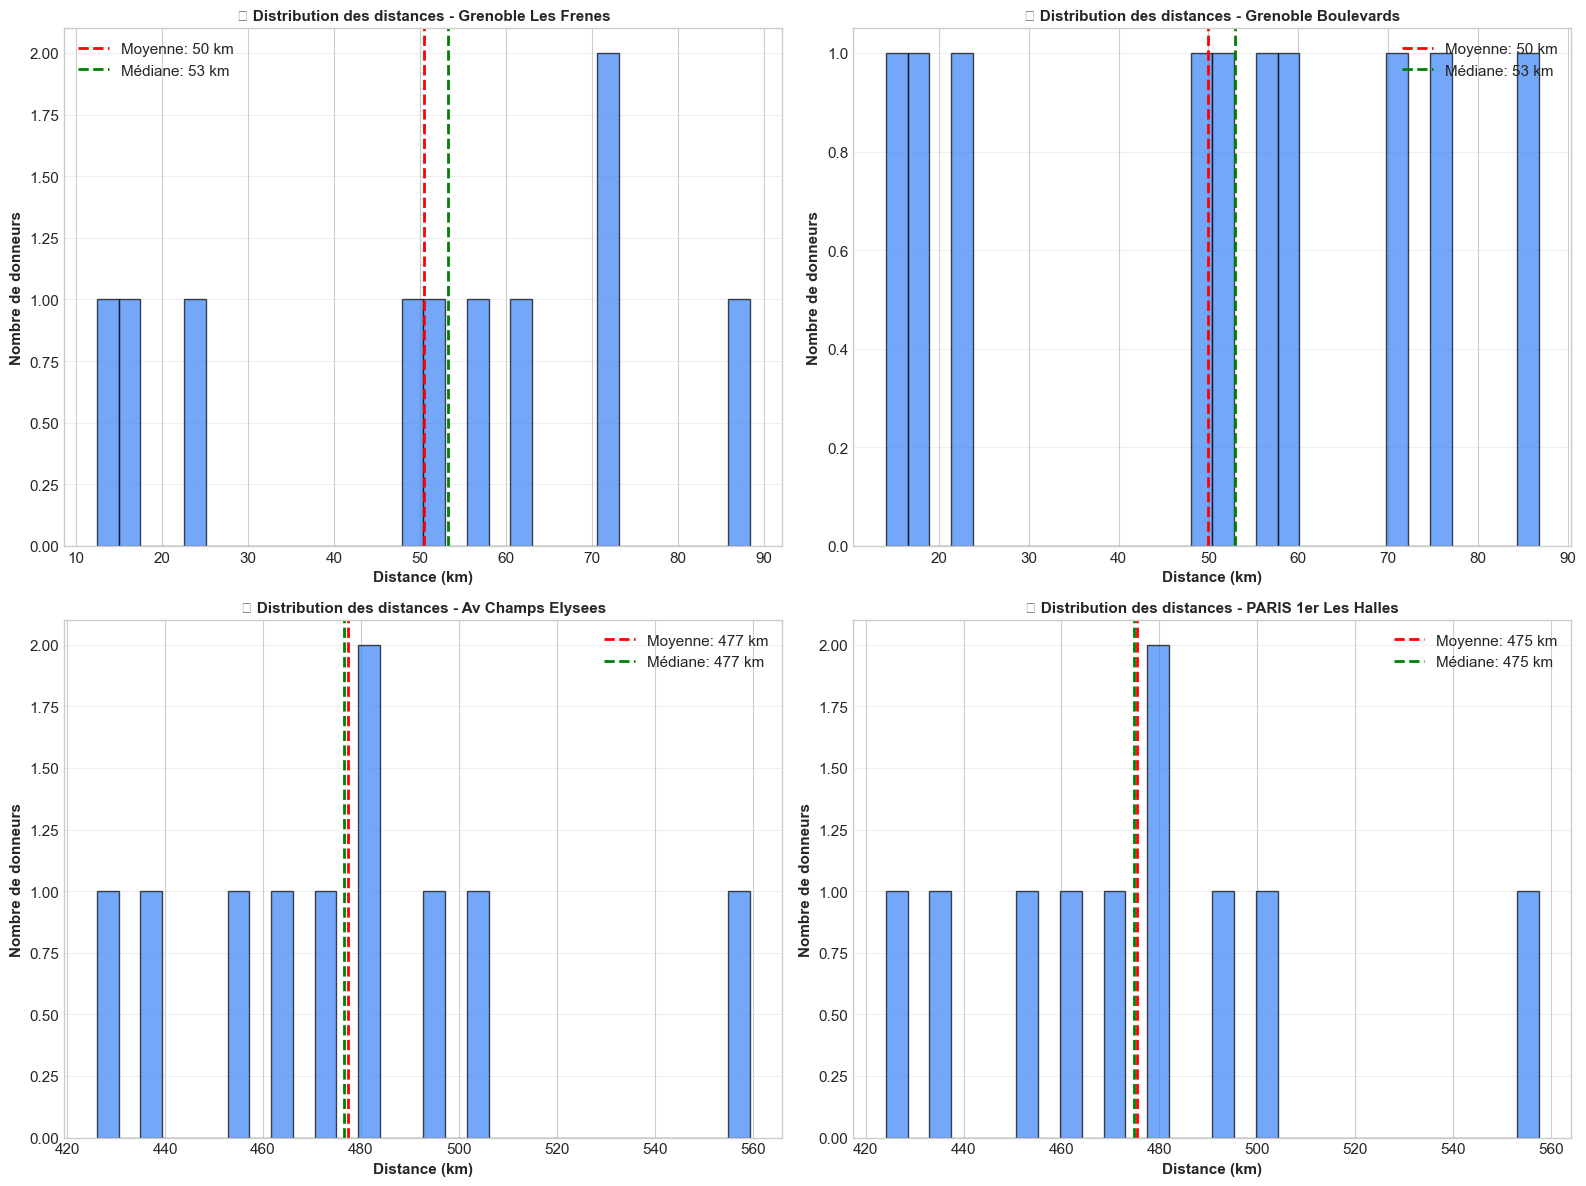


6️⃣ COMPARAISON DONNEURS VS STATIONS TRAITÉES
✅ Comparaison traitées/donneuses sauvegardée


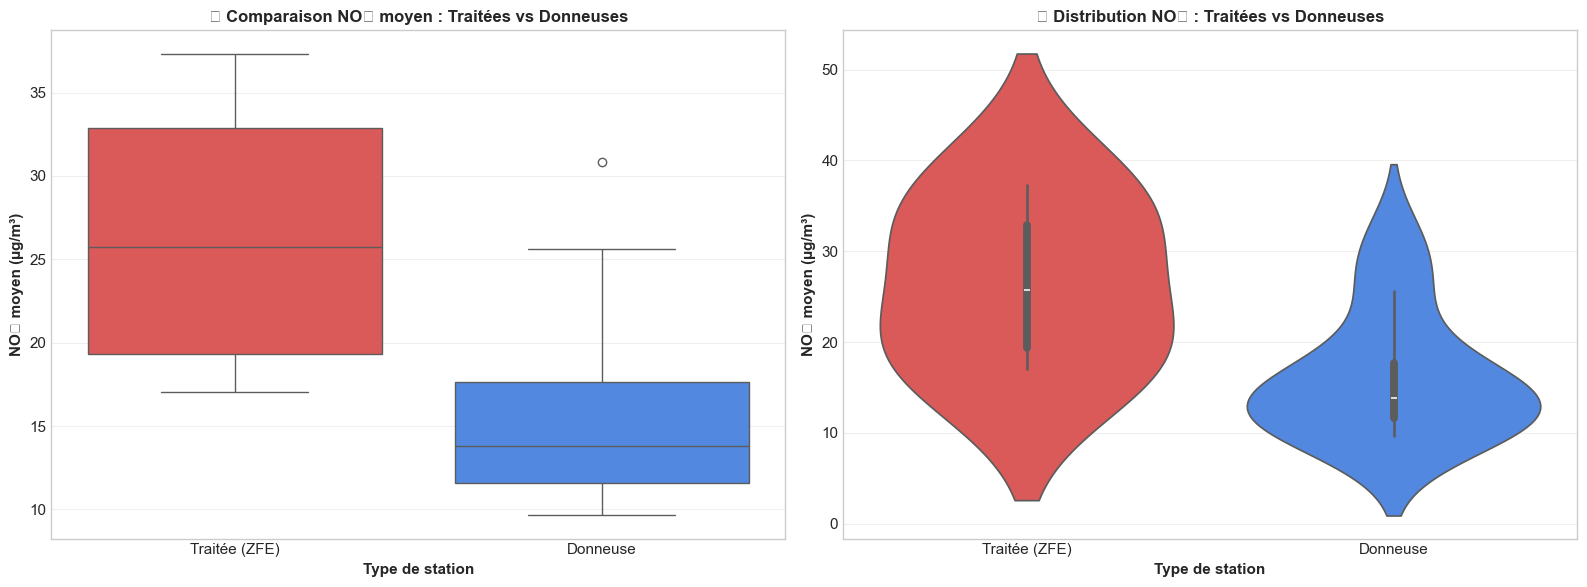


📊 STATISTIQUES COMPARATIVES :

Stations traitées (ZFE) :
        station_name  no2_mean   no2_std  no2_median
 Grenoble Les Frenes 17.021747  9.821403        15.0
 Grenoble Boulevards 37.338978 14.901926        37.0
   Av Champs Elysees 31.363383 15.221167        29.0
PARIS 1er Les Halles 20.107545 11.486412        18.0

Moyenne globale traitées : 26.46 ± 9.52 µg/m³

Stations donneuses :
Moyenne globale donneurs : 16.20 ± 6.92 µg/m³
Médiane : 13.83 µg/m³
Min - Max : 9.64 - 30.85 µg/m³

7️⃣ ÉVOLUTION TEMPORELLE - MOYENNE DES DONNEURS
✅ Évolution temporelle sauvegardée


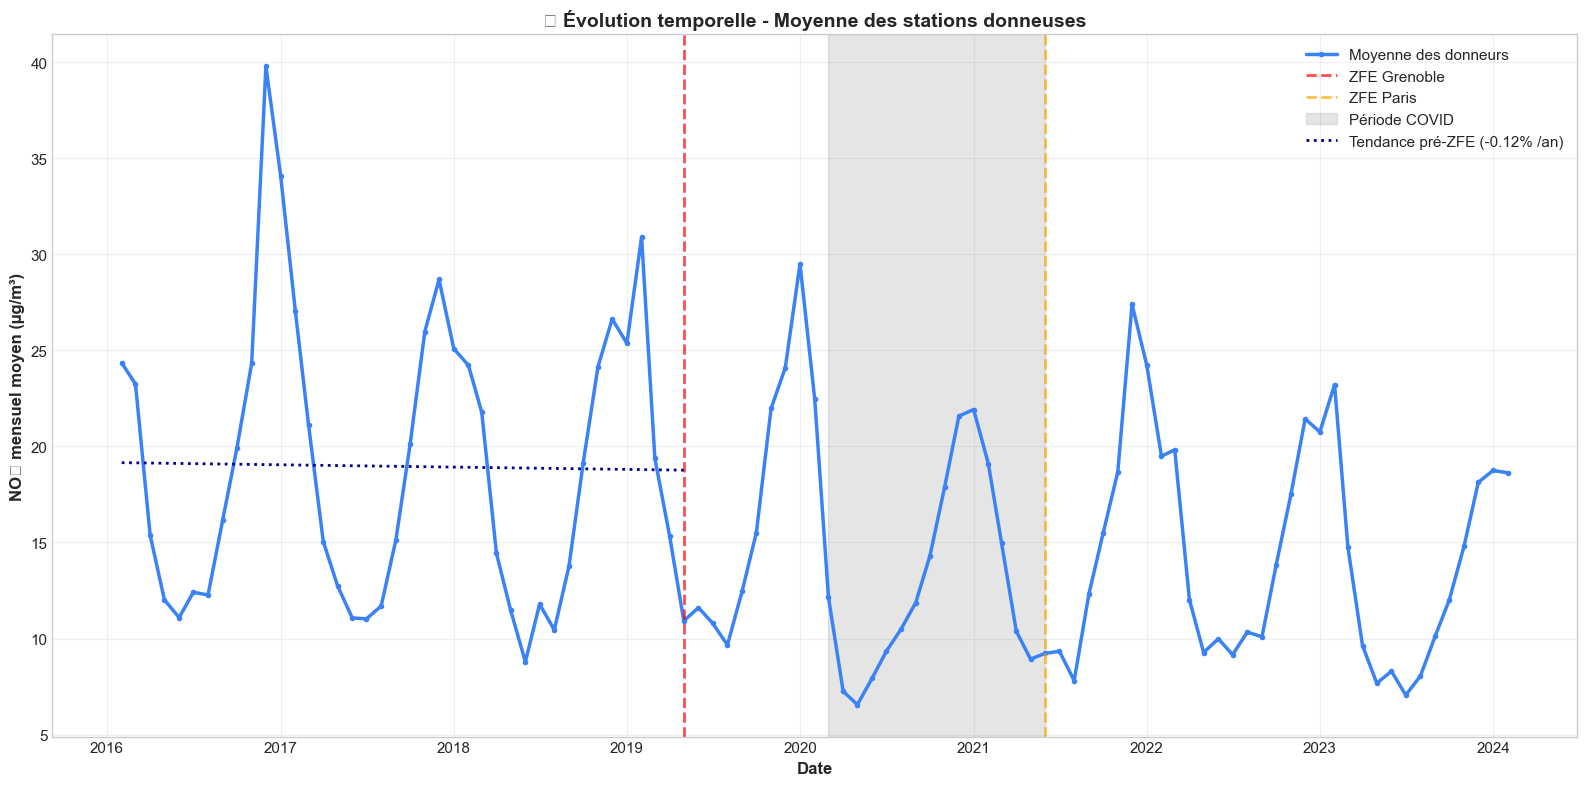


📝 RÉSUMÉ - ANALYSE DES DONNEURS

✅ CARACTÉRISTIQUES DU POOL DE CONTRÔLE :
  • Nombre de stations : 10
  • Villes représentées : 10
  • Types de stations : Fond, Trafic
  • Période couverte : 2016-02-05 → 2024-02-04

📊 QUALITÉ DU POOL :
  • NO₂ moyen donneurs : 16.20 ± 6.92 µg/m³
  • NO₂ moyen traitées : 26.46 ± 9.52 µg/m³
  • Différence : 10.26 µg/m³

🗺️ RÉPARTITION GÉOGRAPHIQUE :
  • Distance moyenne aux stations traitées : 263 km
  • Distance médiane : 256 km
  • Couverture : Diversifiée (grandes villes françaises)

🎯 FICHIERS GÉNÉRÉS :
  ✓ stats_donneurs_meta.csv
  ✓ stats_donneurs_distances.csv
  ✓ stats_donneurs_carte_france.png
  ✓ stats_donneurs_cartes_regionales.png
  ✓ stats_donneurs_repartition_types.png
  ✓ stats_donneurs_distributions_distances.png
  ✓ stats_donneurs_comparaison_traitees.png
  ✓ stats_donneurs_evolution_temporelle.png

✅ ANALYSE DES DONNEURS TERMINÉE


In [ ]:
"""
ANALYSE APPROFONDIE DES STATIONS DONNEUSES
Cartographie, statistiques descriptives et validation du pool de contrôle
"""

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json
from shapely.geometry import Point, shape
from shapely.ops import unary_union
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

# ============================================================================
# 0. CHARGEMENT DES DONNÉES
# ============================================================================

HERE = Path().resolve()
ROOT = HERE.parent if 'zfe-scm' in str(HERE) else HERE
DATA = ROOT / "data"

print("=" * 80)
print("🔍 ANALYSE APPROFONDIE DES STATIONS DONNEUSES")
print("=" * 80)

# Charger les données
donors_daily = pd.read_csv(DATA / "no2_all_stations_daily_clean.csv")
donors_daily['date'] = pd.to_datetime(donors_daily['date'])
donors_daily['station_id'] = donors_daily['station_id'].astype(str).str.strip()

grenoble_daily = pd.read_csv(DATA / "pollution_grenoble_no2_daily_clean.csv")
grenoble_daily['date'] = pd.to_datetime(grenoble_daily['date'])

paris_daily = pd.read_csv(DATA / "pollution_paris_no2_daily_clean.csv")
paris_daily['date'] = pd.to_datetime(paris_daily['date'])

# Métadonnées ZFE
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
zfe_meta['first_date_debut'] = pd.to_datetime(zfe_meta['first_date_debut'])

print(f"\n📊 Données chargées :")
print(f"  • Stations donneuses : {donors_daily['station_id'].nunique()}")
print(f"  • Observations totales : {len(donors_daily):,}")
print(f"  • Période : {donors_daily['date'].min().date()} → {donors_daily['date'].max().date()}")

# ============================================================================
# 0. MÉTADONNÉES DES DONNEURS - TABLE COMPLÈTE
# ============================================================================

print("\n" + "=" * 80)
print("1️⃣ MÉTADONNÉES DES STATIONS DONNEUSES")
print("=" * 80)

# Créer table meta donneurs
donors_meta = (
    donors_daily
    .groupby(['station_id', 'station_name', 'station_env', 'station_influence'])
    .agg({
        'lat': 'first',
        'lon': 'first',
        'date': ['min', 'max'],
        'no2_ug_m3': ['count', 'mean', 'std']
    })
    .reset_index()
)

# Aplatir les colonnes multi-index
donors_meta.columns = ['station_id', 'station_name', 'station_env', 'station_influence',
                       'lat', 'lon', 'date_min', 'date_max', 
                       'n_obs', 'no2_mean', 'no2_std']

# Calculer durée de couverture
donors_meta['duree_jours'] = (donors_meta['date_max'] - donors_meta['date_min']).dt.days

# Identifier la ville (extraction basique depuis le nom)
donors_meta['ville'] = donors_meta['station_name'].str.split().str[0]

print("\n📋 TABLE DES STATIONS DONNEUSES :")
print(donors_meta[['ville', 'station_name', 'station_env', 'station_influence', 
                   'n_obs', 'no2_mean', 'duree_jours']].to_string(index=False))

# Sauvegarder
donors_meta.to_csv(DATA / 'stats_donneurs_meta.csv', index=False)
print(f"\n✅ Table sauvegardée : stats_donneurs_meta.csv")



2️⃣ RÉPARTITION PAR TYPE DE STATION

📊 Répartition des donneurs :
                               n_stations  no2_mean  no2_std
station_env station_influence                               
Périurbaine Fond                        2     11.68     2.89
Urbaine     Fond                        6     13.69     2.87
            Trafic                      2     28.23     3.71
✅ Graphique sauvegardé : stats_donneurs_repartition_types.png


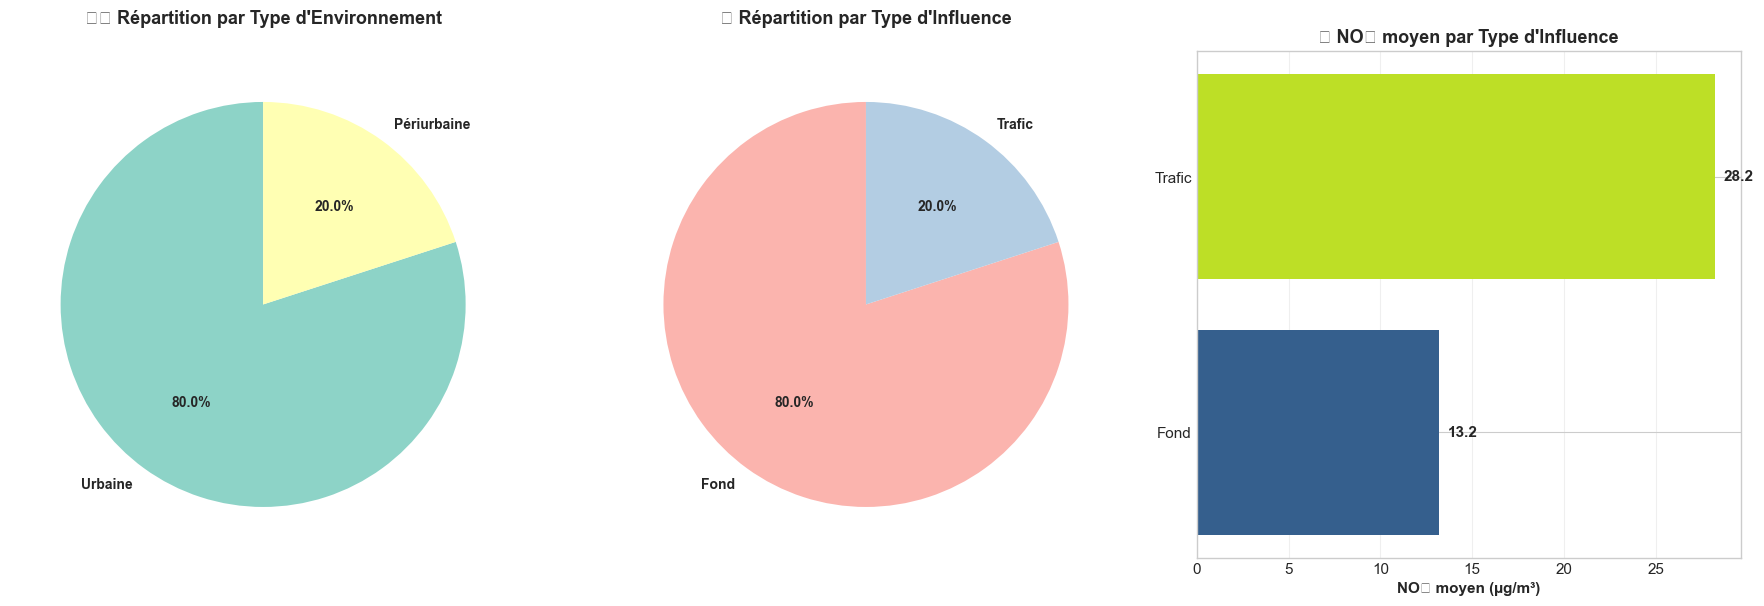

In [19]:
# ============================================================================
# 2. STATISTIQUES DESCRIPTIVES PAR TYPE DE STATION
# ============================================================================

print("\n" + "=" * 80)
print("2️⃣ RÉPARTITION PAR TYPE DE STATION")
print("=" * 80)

# Compter par type
type_counts = donors_meta.groupby(['station_env', 'station_influence']).agg({
    'station_id': 'count',
    'no2_mean': ['mean', 'std']
}).round(2)

type_counts.columns = ['n_stations', 'no2_mean', 'no2_std']
print("\n📊 Répartition des donneurs :")
print(type_counts)

# Graphique
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1 : Répartition par environnement
ax1 = axes[0]
env_counts = donors_meta['station_env'].value_counts()
colors = plt.cm.Set3(range(len(env_counts)))
wedges, texts, autotexts = ax1.pie(env_counts.values, labels=env_counts.index, 
                                     autopct='%1.1f%%', colors=colors,
                                     startangle=90, textprops={'fontsize': 10, 'weight': 'bold'})
ax1.set_title('🏙️ Répartition par Type d\'Environnement', fontsize=13, fontweight='bold', pad=20)

# Subplot 2 : Répartition par influence
ax2 = axes[1]
inf_counts = donors_meta['station_influence'].value_counts()
colors2 = plt.cm.Pastel1(range(len(inf_counts)))
wedges, texts, autotexts = ax2.pie(inf_counts.values, labels=inf_counts.index, 
                                     autopct='%1.1f%%', colors=colors2,
                                     startangle=90, textprops={'fontsize': 10, 'weight': 'bold'})
ax2.set_title('🚗 Répartition par Type d\'Influence', fontsize=13, fontweight='bold', pad=20)

# Subplot 3 : NO2 moyen par type
ax3 = axes[2]
type_no2 = donors_meta.groupby('station_influence')['no2_mean'].mean().sort_values()
bars = ax3.barh(range(len(type_no2)), type_no2.values, color=plt.cm.viridis(np.linspace(0.3, 0.9, len(type_no2))))
ax3.set_yticks(range(len(type_no2)))
ax3.set_yticklabels(type_no2.index)
ax3.set_xlabel('NO₂ moyen (µg/m³)', fontweight='bold')
ax3.set_title('📊 NO₂ moyen par Type d\'Influence', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Annotations
for i, (val, label) in enumerate(zip(type_no2.values, type_no2.index)):
    ax3.text(val + 0.5, i, f'{val:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(DATA / 'stats_donneurs_repartition_types.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : stats_donneurs_repartition_types.png")
plt.show()



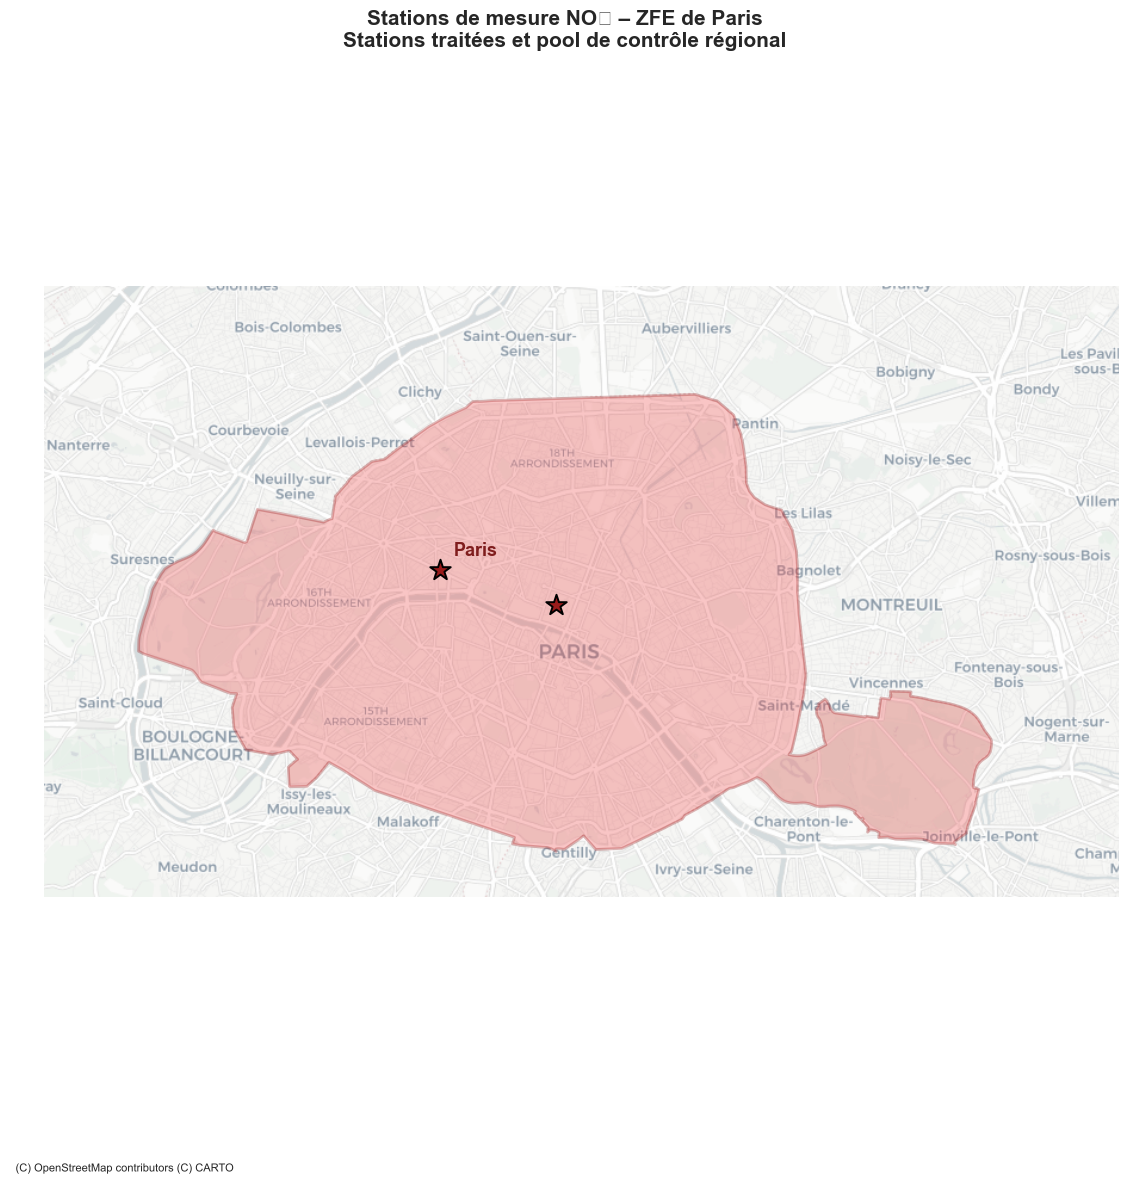

✅ Carte Paris sauvegardée : carte_paris_zoom.png


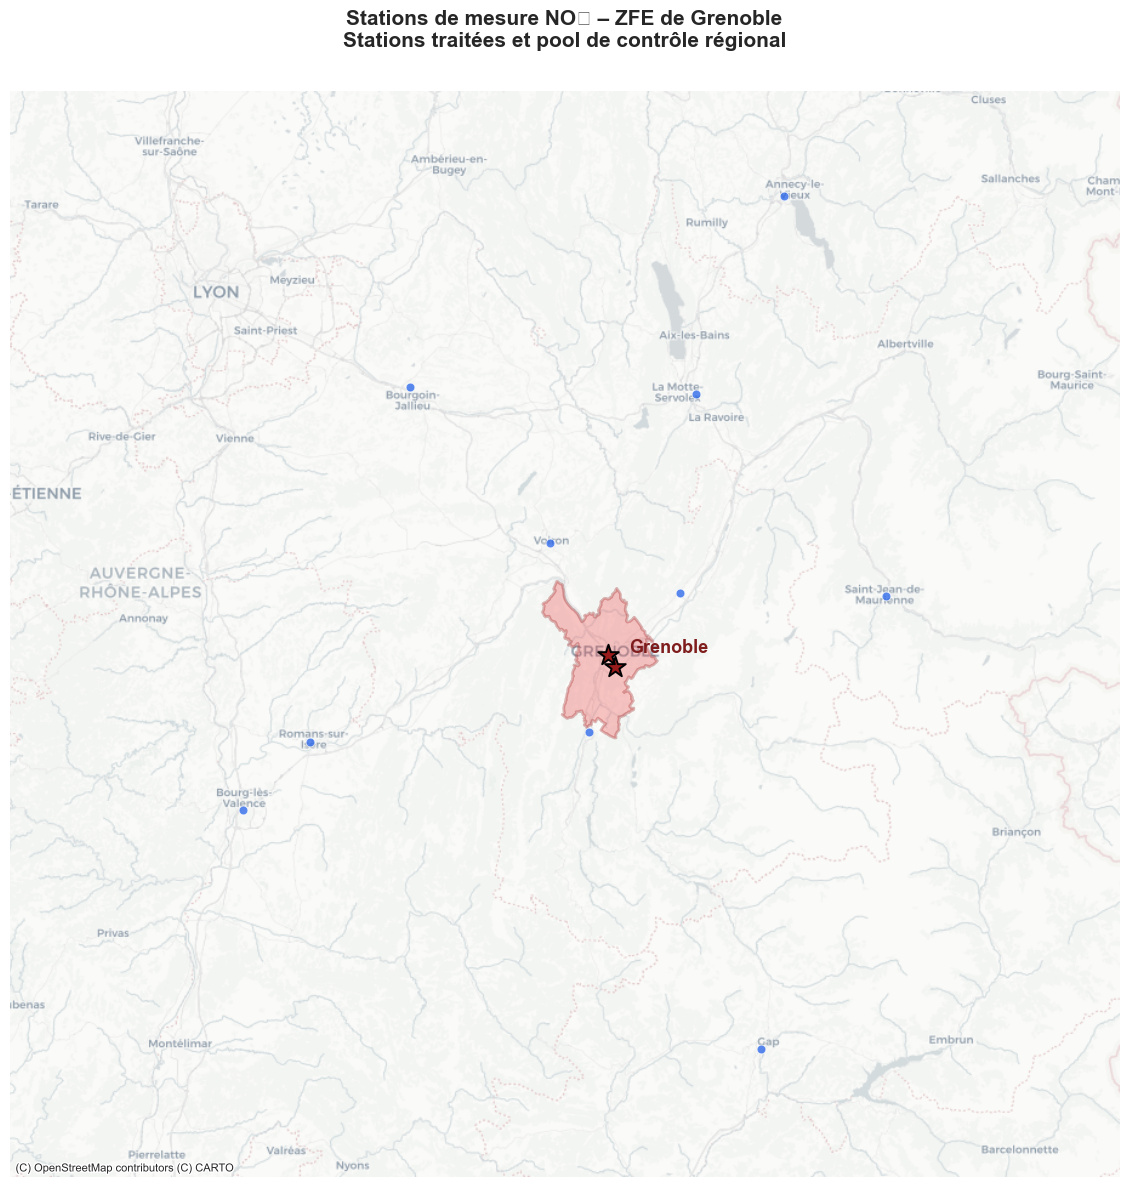

✅ Carte Grenoble sauvegardée : carte_grenoble_zoom.png


In [25]:
# ============================================================================
# CARTOGRAPHIES ZOOMÉES ZFE – PARIS & GRENOBLE
# Fond de carte via Contextily (API)
# Emprise basée sur donneurs + ZFE (robuste)
# ============================================================================

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import json
from shapely.geometry import Point, shape

# ----------------------------------------------------------------------------
# 1. CRS
# ----------------------------------------------------------------------------
CRS_WGS84 = "EPSG:4326"
CRS_WEB = "EPSG:3857"  # requis pour Contextily

# ----------------------------------------------------------------------------
# 2. GEODATAFRAMES
# ----------------------------------------------------------------------------

# Stations donneuses
gdf_donors = gpd.GeoDataFrame(
    donors_meta,
    geometry=gpd.points_from_xy(donors_meta.lon, donors_meta.lat),
    crs=CRS_WGS84
)

# Stations traitées (Paris + Grenoble)
treated_stations = []
for df, ville in [(grenoble_daily, "Grenoble"), (paris_daily, "Paris")]:
    stations = df[["station_id", "station_name", "lat", "lon"]].drop_duplicates()
    for _, row in stations.iterrows():
        treated_stations.append({
            "station_id": row["station_id"],
            "station_name": row["station_name"],
            "ville": ville,
            "geometry": Point(row["lon"], row["lat"])
        })

gdf_treated = gpd.GeoDataFrame(treated_stations, crs=CRS_WGS84)

# ----------------------------------------------------------------------------
# 3. ZFE
# ----------------------------------------------------------------------------

with open(DATA / "aires.geojson", encoding="utf-8") as f:
    zfe_geojson = json.load(f)

zfe_features = []
for feat in zfe_geojson["features"]:
    pub = feat.get("publisher", {})
    if pub.get("zfe_id") in ["PARIS", "GRENOBLE"]:
        zfe_features.append({
            "zfe_id": pub.get("zfe_id"),
            "geometry": shape(feat["geometry"])
        })

gdf_zfe = gpd.GeoDataFrame(zfe_features, crs=CRS_WGS84)

# ----------------------------------------------------------------------------
# 4. REPROJECTION POUR CONTEXTILY
# ----------------------------------------------------------------------------

gdf_donors = gdf_donors.to_crs(CRS_WEB)
gdf_treated = gdf_treated.to_crs(CRS_WEB)
gdf_zfe = gdf_zfe.to_crs(CRS_WEB)

# ----------------------------------------------------------------------------
# 5. FONCTION DE CARTE ZOOMÉE ROBUSTE
# ----------------------------------------------------------------------------

def plot_zoom_map(ville, max_distance_km=180, padding_ratio=0.15):
    """
    Carte zoomée autour d'une ZFE
    Emprise calculée à partir des donneurs + ZFE + station traitée
    """

    max_distance_m = max_distance_km * 1_000

    # Sélections
    treated_city = gdf_treated[gdf_treated["ville"] == ville]
    zfe_city = gdf_zfe[gdf_zfe["zfe_id"] == ville.upper()]
    center = treated_city.geometry.iloc[0]

    # Distance donneurs → station traitée
    donors = gdf_donors.copy()
    donors["dist"] = donors.geometry.distance(center)
    donors_local = donors[donors["dist"] <= max_distance_m]

    # Géométries utiles
    all_geoms = pd.concat(
        [donors_local.geometry, zfe_city.geometry, treated_city.geometry]
    )

    xmin, ymin, xmax, ymax = all_geoms.total_bounds

    # Padding proportionnel
    dx = xmax - xmin
    dy = ymax - ymin
    xmin -= dx * padding_ratio
    xmax += dx * padding_ratio
    ymin -= dy * padding_ratio
    ymax += dy * padding_ratio

    # Forcer une emprise carrée (évite les fonds blancs)
    width = xmax - xmin
    height = ymax - ymin
    if width > height:
        diff = width - height
        ymin -= diff / 2
        ymax += diff / 2
    else:
        diff = height - width
        xmin -= diff / 2
        xmax += diff / 2

    # ------------------------------------------------------------------------
    # PLOT
    # ------------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(12, 12))

    # ZFE
    zfe_city.plot(
        ax=ax,
        color="#ef4444",
        alpha=0.3,
        edgecolor="#991b1b",
        linewidth=2,
        zorder=2
    )

    # Donneurs
    donors_local.plot(
        ax=ax,
        color="#2563eb",
        markersize=40,
        alpha=0.75,
        edgecolor="white",
        linewidth=0.6,
        zorder=3
    )

    # Station traitée
    treated_city.plot(
        ax=ax,
        color="#991b1b",
        markersize=240,
        marker="*",
        edgecolor="black",
        linewidth=1.4,
        zorder=4
    )

    # Annotation ville
    ax.annotate(
        ville,
        xy=(center.x, center.y),
        xytext=(10, 10),
        textcoords="offset points",
        fontsize=13,
        fontweight="bold",
        color="#7f1d1d"
    )

    # Fond de carte (API)
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.Positron,
        attribution_size=8,
        zorder=1
    )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_title(
        f"Stations de mesure NO₂ – ZFE de {ville}\n"
        f"Stations traitées et pool de contrôle régional",
        fontsize=15,
        fontweight="bold",
        pad=15
    )

    ax.set_axis_off()

    plt.tight_layout()
    plt.savefig(DATA / f"carte_{ville.lower()}_zoom.png", dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ Carte {ville} sauvegardée : carte_{ville.lower()}_zoom.png")

# ----------------------------------------------------------------------------
# 6. GÉNÉRATION DES CARTES
# ----------------------------------------------------------------------------

plot_zoom_map("Paris", max_distance_km=200)
plot_zoom_map("Grenoble", max_distance_km=180)



5️⃣ ANALYSE DE PROXIMITÉ GÉOGRAPHIQUE
✅ Distances calculées et sauvegardées : stats_donneurs_distances.csv

6️⃣ COMPARAISON DONNEURS VS STATIONS TRAITÉES

📊 TABLEAU COMPARATIF SYNTHÉTIQUE :
            Groupe  NO₂ moyen (µg/m³)  Écart-type  Médiane   Min   Max  Nombre de stations
 Stations traitées              26.46        9.52    25.74 17.02 37.34                   4
Stations donneuses              16.20        6.92    13.83  9.64 30.85                  10


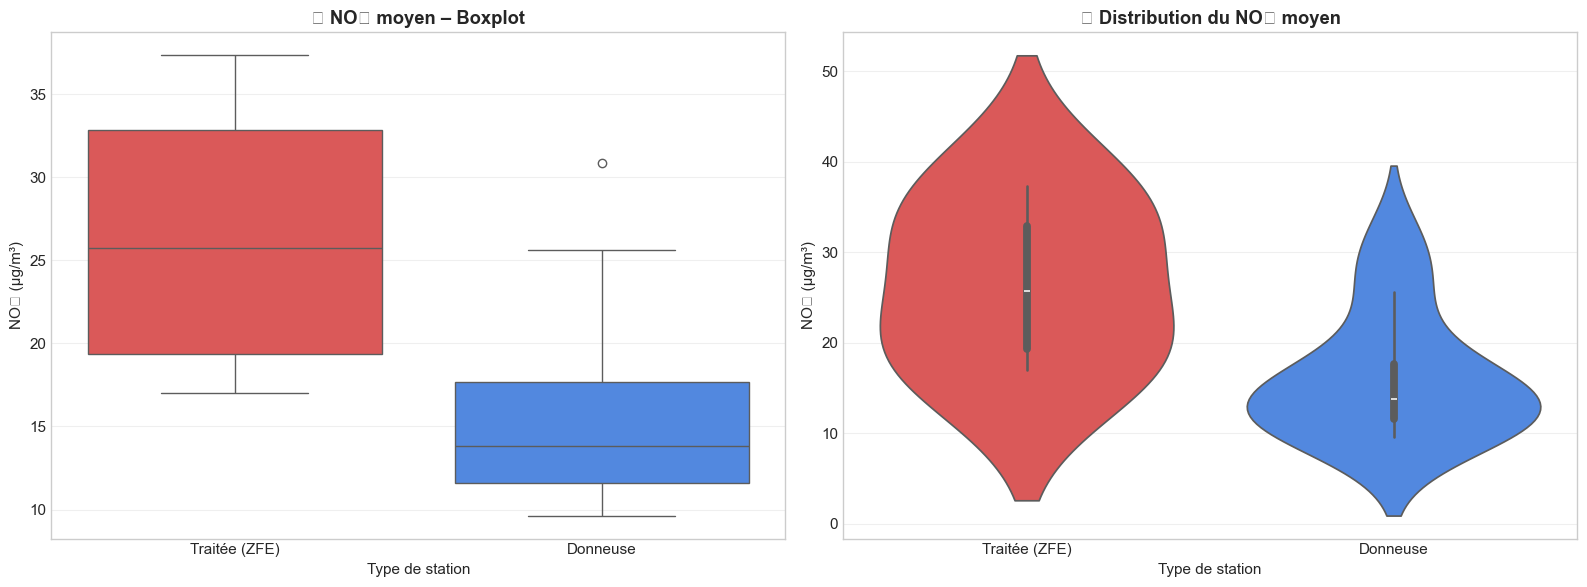

✅ Comparaison traitées / donneuses sauvegardée : stats_donneurs_comparaison_traitees.png


station_name     ville           type   no2_mean    no2_std  \
0   Grenoble Les Frenes  Grenoble  Traitée (ZFE)  17.021747   9.821403   
1   Grenoble Boulevards  Grenoble  Traitée (ZFE)  37.338978  14.901926   
2     Av Champs Elysees     Paris  Traitée (ZFE)  31.363383  15.221167   
3  PARIS 1er Les Halles     Paris  Traitée (ZFE)  20.107545  11.486412   

   no2_median  n_obs  
0        15.0   2919  
1        37.0   2917  
2        29.0   3015  
3        18.0   2253

no2_mean
count  10.000000
mean   16.195738
std     6.920323
min     9.636333
25%    11.593747
50%    13.831425
75%    17.660481
max    30.847899

In [31]:
# ============================================================================
# 5. ANALYSE DE PROXIMITÉ GÉOGRAPHIQUE (VERSION CORRECTE)
# ============================================================================

print("\n" + "=" * 80)
print("5️⃣ ANALYSE DE PROXIMITÉ GÉOGRAPHIQUE")
print("=" * 80)

from geopy.distance import geodesic

def calculate_distances(treated_station, donors_df):
    distances = []
    treated_coords = (treated_station["lat"], treated_station["lon"])

    for _, donor in donors_df.iterrows():
        donor_coords = (donor["lat"], donor["lon"])
        dist_km = geodesic(treated_coords, donor_coords).kilometers

        distances.append({
            "treated_station": treated_station["station_name"],
            "donor_station": donor["station_name"],
            "donor_ville": donor["ville"],
            "distance_km": dist_km,
            "donor_no2_mean": donor["no2_mean"]
        })

    return pd.DataFrame(distances)


# ---------------------------------------------------------------------------
# COORDONNÉES DES STATIONS TRAITÉES (SOURCE BRUTE)
# ---------------------------------------------------------------------------

treated_coords_list = []

for df, ville in [(grenoble_daily, "Grenoble"), (paris_daily, "Paris")]:
    stations = df[["station_name", "lat", "lon"]].drop_duplicates()
    for _, row in stations.iterrows():
        treated_coords_list.append({
            "station_name": row["station_name"],
            "lat": row["lat"],
            "lon": row["lon"]
        })

treated_coords_df = pd.DataFrame(treated_coords_list)

# ---------------------------------------------------------------------------
# CALCUL DES DISTANCES
# ---------------------------------------------------------------------------

all_distances = []

for _, treated in treated_coords_df.iterrows():
    all_distances.append(
        calculate_distances(treated, donors_meta)
    )

distances_df = pd.concat(all_distances, ignore_index=True)

# Sauvegarde
distances_df.to_csv(DATA / "stats_donneurs_distances.csv", index=False)

print("✅ Distances calculées et sauvegardées : stats_donneurs_distances.csv")

# ============================================================================
# 6. COMPARAISON STATISTIQUE DONNEURS VS STATIONS TRAITÉES
# ============================================================================

print("\n" + "=" * 80)
print("6️⃣ COMPARAISON DONNEURS VS STATIONS TRAITÉES")
print("=" * 80)

import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# 1. STATISTIQUES DES STATIONS TRAITÉES
# ---------------------------------------------------------------------------

treated_stats = []

for df, ville in [(grenoble_daily, "Grenoble"), (paris_daily, "Paris")]:
    for station_id in df["station_id"].unique():
        station_data = df[df["station_id"] == station_id]

        treated_stats.append({
            "station_name": station_data["station_name"].iloc[0],
            "ville": ville,
            "type": "Traitée (ZFE)",
            "no2_mean": station_data["no2_ug_m3"].mean(),
            "no2_std": station_data["no2_ug_m3"].std(),
            "no2_median": station_data["no2_ug_m3"].median(),
            "n_obs": len(station_data)
        })

treated_stats_df = pd.DataFrame(treated_stats)

# ---------------------------------------------------------------------------
# 2. STATISTIQUES DES STATIONS DONNEUSES
# ---------------------------------------------------------------------------

donors_stats_df = donors_meta.copy()
donors_stats_df["type"] = "Donneuse"

# Sécurité : on s'assure que la colonne existe
assert "no2_mean" in donors_stats_df.columns, "Colonne no2_mean absente de donors_meta"

# ---------------------------------------------------------------------------
# 3. TABLEAU COMPARATIF SYNTHÉTIQUE
# ---------------------------------------------------------------------------

summary_table = pd.DataFrame({
    "Groupe": ["Stations traitées", "Stations donneuses"],
    "NO₂ moyen (µg/m³)": [
        treated_stats_df["no2_mean"].mean(),
        donors_stats_df["no2_mean"].mean()
    ],
    "Écart-type": [
        treated_stats_df["no2_mean"].std(),
        donors_stats_df["no2_mean"].std()
    ],
    "Médiane": [
        treated_stats_df["no2_mean"].median(),
        donors_stats_df["no2_mean"].median()
    ],
    "Min": [
        treated_stats_df["no2_mean"].min(),
        donors_stats_df["no2_mean"].min()
    ],
    "Max": [
        treated_stats_df["no2_mean"].max(),
        donors_stats_df["no2_mean"].max()
    ],
    "Nombre de stations": [
        len(treated_stats_df),
        len(donors_stats_df)
    ]
})

print("\n📊 TABLEAU COMPARATIF SYNTHÉTIQUE :")
print(summary_table.round(2).to_string(index=False))

# ---------------------------------------------------------------------------
# 4. VISUALISATIONS COMPARATIVES
# ---------------------------------------------------------------------------

all_stats = pd.concat([
    treated_stats_df[["type", "no2_mean"]].rename(columns={"no2_mean": "NO2"}),
    donors_stats_df[["type", "no2_mean"]].rename(columns={"no2_mean": "NO2"})
])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
sns.boxplot(
    data=all_stats,
    x="type",
    y="NO2",
    ax=axes[0],
    palette=["#ef4444", "#3b82f6"]
)
axes[0].set_title("📦 NO₂ moyen – Boxplot", fontweight="bold")
axes[0].set_xlabel("Type de station")
axes[0].set_ylabel("NO₂ (µg/m³)")
axes[0].grid(True, alpha=0.3, axis="y")

# Violinplot
sns.violinplot(
    data=all_stats,
    x="type",
    y="NO2",
    ax=axes[1],
    palette=["#ef4444", "#3b82f6"],
    inner="box"
)
axes[1].set_title("🎻 Distribution du NO₂ moyen", fontweight="bold")
axes[1].set_xlabel("Type de station")
axes[1].set_ylabel("NO₂ (µg/m³)")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(DATA / "stats_donneurs_comparaison_traitees.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Comparaison traitées / donneuses sauvegardée : stats_donneurs_comparaison_traitees.png")

# ---------------------------------------------------------------------------
# 5. AFFICHAGE DE CONTRÔLE (OPTIONNEL MAIS RECOMMANDÉ)
# ---------------------------------------------------------------------------

display(treated_stats_df.head())
display(donors_stats_df[["no2_mean"]].describe())
